In [1]:
# Temel kütüphaneler
import os
import re
import shutil
import joblib
import warnings
import math
from math import pi
from pathlib import Path
from datetime import date
from collections import Counter
from typing import Iterable, List, Optional, Tuple, Set, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

import requests
import unicodedata
import difflib
from concurrent.futures import ThreadPoolExecutor

from haversine import haversine, Unit
from scipy.stats import ks_2samp, wasserstein_distance
from skimage.feature import shape_index
from rapidfuzz import process, fuzz
import gmpy2

import missingno as msno
from kaggle.api.kaggle_api_extended import KaggleApi

import utils
import importlib
importlib.reload(utils)

# sklearn & imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, RobustScaler, StandardScaler, MinMaxScaler,
    OneHotEncoder, LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    RocCurveDisplay,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    accuracy_score
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Genel ayarlar
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [3]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Tam yol
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)



In [4]:
df_customers = utils.load(customers_path)
df_geo_avg = utils.load(geolocation_path)

In [5]:
# zip prefix bazında özet tablo
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # kaç farklı şehir var
        state_count=("geolocation_state", "nunique"),   # kaç farklı eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satır sayısı (koordinat sayısı)
        lat_std=("geolocation_lat", "std"),             # enlem sapması
        lng_std=("geolocation_lng", "std")              # boylam sapması
    )
    .reset_index()
)

summary.head()


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
0,1001,2,1,26,0.001,0.000
1,1002,2,1,13,0.001,0.001
2,1003,2,1,17,0.000,0.001
3,1004,2,1,22,0.001,0.000
4,1005,2,1,25,0.000,0.001


In [6]:
# %95 eşiklerini hesapla
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# geniş alan zip’leri seç
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

print("Lat std için %95 eşik:", lat_thresh)
print("Lng std için %95 eşik:", lng_thresh)
print("Eşik üzerinde kaç kayıt var:", len(wide_zips))
wide_zips.head(10)



Lat std için %95 eşik: 0.04056525284991052
Lng std için %95 eşik: 0.045473794164270054
Eşik üzerinde kaç kayıt var: 1272


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
130,1239,2,1,152,0.012,0.066
202,1417,2,1,86,0.026,0.079
215,1430,2,1,11,0.145,0.013
216,1431,2,1,13,0.117,0.011
257,1513,1,1,24,0.023,0.072
406,2169,2,1,45,0.106,0.071
458,2237,1,1,8,0.136,0.045
508,2290,2,1,3,0.109,0.047
531,2323,2,1,56,0.044,0.053
532,2324,2,1,48,0.087,0.033


In [7]:
# summary tablosundan gerekli sütunları alıyoruz
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Durum sütunu
def zip_type(row):
    if row['state_count'] > 1:
        return 'Farklı eyaletlerde'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Aynı eyalette farklı şehirler'
    else:
        return 'Tek şehir, tek eyalet'

zip_summary['type'] = zip_summary.apply(zip_type, axis=1)


zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_summary_sorted.head(10)

,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde
8,6900,5,1,Aynı eyalette farklı şehirler
9,13318,5,1,Aynı eyalette farklı şehirler


### Aynı eyalette birden fazla şehir

In [8]:
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

### Farklı eyaletleri kapsayan zip kodları ve eyalet isimleri

In [9]:
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# İlk 10 satırı göster
multi_state_zips.head(10)

# İstersen tüm listeyi görmek için:
multi_state_zips


,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde


In [10]:
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states


,geolocation_zip_code_prefix,geolocation_state_x,geolocation_state_y
0,2116,2,"[SP, RN]"
1,4011,2,"[SP, AC]"
2,21550,2,"[RJ, AC]"
3,23056,2,"[RJ, AC]"
4,72915,2,"[GO, DF]"
5,78557,2,"[MT, RO]"
6,79750,2,"[MS, RS]"
7,80630,2,"[PR, SC]"


In [11]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

,geolocation_zip_code_prefix,geolocation_city_x,geolocation_city_y
0,1001,2,"[sao paulo, são paulo]"
1,1002,2,"[sao paulo, são paulo]"
2,1003,2,"[sao paulo, são paulo]"
3,1004,2,"[sao paulo, são paulo]"
4,1005,2,"[sao paulo, são paulo]"


In [12]:
# Her zip için state ve city bilgisi
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # her zip içindeki toplam farklı şehir sayısı
    )
    .reset_index()
)

# Sıralama: önce state_count, sonra max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_info_sorted.head(10)

,geolocation_zip_code_prefix,state_count,states,max_city_count
0,72915,2,"[GO, DF]",3
1,2116,2,"[SP, RN]",2
2,4011,2,"[SP, AC]",2
3,78557,2,"[MT, RO]",2
4,80630,2,"[PR, SC]",2
5,21550,2,"[RJ, AC]",1
6,23056,2,"[RJ, AC]",1
7,79750,2,"[MS, RS]",1
8,6900,1,[SP],5
9,13318,1,[SP],5


In [13]:
df_orderitems = utils.load(orderitems_path)
df_orderpayments = utils.load(orderpayments_path)
df_orderreviews = utils.load(orderreviews_path)
df_orders = utils.load(orders_path)
df_products = utils.load(products_path)
df_sellers = utils.load(sellers_path)

### Farkli yazim sekilleri nedeniyle tekrar eden ayni sehir ve eyaletlerin tespiti

In [14]:
# 1.  Gelişmiş şehir normalizasyonu
def normalize_city_advanced(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Aksanları kaldır
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Nokta, tire, apostrof, boşluk gibi karakterleri kaldır
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name

In [15]:
# 2. Benzer şehirleri gruplayıp tekilleştirme
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # ilk gördüğünü referans al
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping

In [16]:
# 3. Ana fonksiyon (şehir + eyalet)

def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    Tüm şehir isimlerini normalize eder ve benzer şehirleri tekilleştirir.
    """
    # Normalize edilmiş şehir sütunu
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # Eyalet bazında şehir listesi
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Eyalet bazlı eşleşmeler
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Orijinal tabloyu güncelle
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Geçici sütunu kaldır
    df = df.drop(columns=['city_norm'])
    
    return df

In [17]:
# geolocation tablosu için
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [18]:
# Customers tablosu için
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')


In [19]:
# Sellers tablosu için
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Temizleme işleminden sonra hala tekrar eden şehir isimleri kaldı mı kontrol

In [20]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Temizlenmiş tabloda hala birbirine benzer şehir var mı diye kontrol eder.
    """
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("✅ Hiç tekrar eden veya benzer şehir kalmadı.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nEyalet: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (benzerlik: {dup[2]:.2f})")



In [21]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [22]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [23]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


# DATA MODELING

-----------------------------
️1-  Basit sayısal ID oluşturma fonksiyonu
-----------------------------

In [24]:
# Prefiksli ID oluşturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map

# Prefiksli ID oluşturma (ID olmayan tablolar)
def create_prefixed_id_no_col(df, new_id_col, prefix):
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


️2- PK’ları Prefiksli ID’ye Çevirme ve Mapping Saklama
-----------------------------


In [25]:
# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (ID olmayan ama ürün sayısı kolonu korunacak)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # PK değil
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")
# Order Payments
df_orderpayments= create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")
# Geolocation (ID yok)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")


In [26]:
# Orders → customer_id_pref ekle
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Order Items → order_id_pref, product_id_pref, seller_id_pref ekle
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Order Payments → order_id_pref ekle
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)

print("Boş kalan customer_id_pref:", df_orders["customer_id_pref"].isnull().sum())
print("Boş kalan order_id_pref (items):", df_orderitems["order_id_pref"].isnull().sum())
print("Boş kalan product_id_pref:", df_orderitems["product_id_pref"].isnull().sum())
print("Boş kalan seller_id_pref:", df_orderitems["seller_id_pref"].isnull().sum())
print("Boş kalan order_id_pref (payments):", df_orderpayments["order_id_pref"].isnull().sum())

Boş kalan customer_id_pref: 0
Boş kalan order_id_pref (items): 0
Boş kalan product_id_pref: 0
Boş kalan seller_id_pref: 0
Boş kalan order_id_pref (payments): 0


In [27]:
# 1. Eşsiz customer_unique_id listesi
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Yeni ID oluştur
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Orijinal tabloya merge ile ekle
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [28]:
#Her customer_unique_id kaç farklı cusUni ile eşleşmiş 
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Eğer her customer_unique_id yalnızca bir cusUni ile eşleşmişse tamamdır
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.")
else:
    print("Dikkat! Bazı müşteri unique ID’leri birden fazla yeni ID ile eşleşmiş:")
    print(problem_customers)



Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.


Zip code ve city/state kolonlarını customers & sellers'tan silinebilir

Orijinal ID’leri sil

In [29]:
# Orijinal ID kolonları
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id"],
    "orders": ["order_id", "customer_id"],
    "order_items": ["order_id", "product_id", "seller_id"],
    "products": ["product_id"],
    "order_payments": ["orderpayment_id", "order_id"],
    "df_geo_avg": []
}

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]

Prefiksli ID’leri başa taşı

In [30]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=None):
    """
    DataFrame kolonlarını yeniden sıralar:
    - Önce Primary Key (prefixed_id_col)
    - Sonra Foreign Key kolonları (fk_cols listesi)
    - Sonra diğer tüm kolonlar
    """
    df = df.copy()
    if fk_cols is None:
        fk_cols = []
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]


# Başta prefiksli ID, FK’lar da başa
df_customers    = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers      = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders       = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems   = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products     = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments= move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg      = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")

In [31]:
df_geo_avg.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [32]:
df_geolocation = df_geo_avg
# 1. GEO tablosundan ortalama koordinat çıkar (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. CUSTOMERS tablosuna ortalama koordinat ekle
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temp kolon gerekmez

# 3. SELLERS tablosuna ortalama koordinat ekle
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

# Artık:
# df_geo_full  -> ham geo data (zip + lat + lng + pk)
# geo_avg      -> zip bazlı ortalama koordinatlar
# df_customers -> müşteri tablosu + ortalama koordinatlar
# df_sellers   -> satıcı tablosu + ortalama koordinatlar


In [33]:
df_geo_avg.head()

,zip_prefix,lat_avg,lng_avg
0,1001,-23.550,-46.634
1,1002,-23.548,-46.635
2,1003,-23.549,-46.636
3,1004,-23.550,-46.635
4,1005,-23.549,-46.637


In [34]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [35]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [36]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})

### Data tablolari yeni klasore (cleaned_data_with_prefix_id) eklenmis durumda.
### Kodu yeniden calistirirsaniz ikinci bir data klasoru olusturulmaz ve 
### Bu klasor eger olusturulmus durumda ise tablolar bu klasore olustururlur.
### Mevcut tablolar onceden var ise , guncellenir. 
### Klasor yok ise bastan olusturulur...

In [37]:
# Kaydedilecek klasör adı
prefix_id_path = Path.cwd() / "cleaned_data_with_prefix_id"

# Her çalıştırmada klasörü sıfırla (varsa sil, sonra yeniden oluştur)
if prefix_id_path.exists():
    shutil.rmtree(prefix_id_path)
prefix_id_path.mkdir(parents=True, exist_ok=True)

# Kaydedilecek DataFrame'ler
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation": df_geolocation,
}

# CSV olarak yaz
for name, df in dfs.items():
    file_path = prefix_id_path / f"{name}.csv"
    df.to_csv(file_path, index=False)
    print(f"{file_path} kaydedildi. shape={df.shape}")

C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\customers.csv kaydedildi. shape=(99441, 7)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\sellers.csv kaydedildi. shape=(3095, 6)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\orders.csv kaydedildi. shape=(99441, 8)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\order_items.csv kaydedildi. shape=(112650, 8)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\products.csv kaydedildi. shape=(32951, 9)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\order_payments.csv kaydedildi. shape=(103886, 6)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefix_id\geo_avg.csv kaydedildi. shape=(19015, 3)
C:\Users\onayk\Desktop\EuroTech_Datascience\Proje\Git_Proje\cleaned_data_with_prefi

### Yeni Olusturulan Dosya Yollari
#### notebook yeniden baslatildiginda direk buradan tablolar yuklenebilir..

In [38]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Tam yol
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [39]:
df_customers = utils.load(new_customers_path)
df_geolocation = utils.load(new_geolocation_path)
df_orderitems = utils.load(new_orderitems_path)
df_orderpayments = utils.load(new_orderpayments_path)
df_orders = utils.load(new_orders_path)
df_products = utils.load(new_products_path)
df_sellers = utils.load(new_sellers_path)
df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


## Mevcut dimension tablolarını kullanarak fact_order_shipments tablosu

Payments kısmında bazı siparişler için birden fazla ödeme yöntemi kullanılması ve taksitli şekilde ödeme gerçekleşmesi sebebiyle ödemelerde ayrı sipariş için birden fazla satır bulunuyor. Her bir siparişi tek satır halinde yazmak için pay_agg isimli bir dataframe oluşturup aggrigasyon işlemleri yapılabilir:


Burada aynı sipariş üzerinde birden fazla ödeme şekli varsa onları bir satıra (payment_types) aralarına / işareti koyarak ayrılıp taksitli satış ödemelerinin taksit sayısının en yükseğini alarak olası taksit sayısı sorgulamalarında kullanılmak üzere dataframe üzerinde bırakıldı(payment_installment_max) ve son olarak ödenen tutarı toplayarak (payment_value_sum) her bir sipariş tutarı için bir toplam ödeme satırı oluşturuldu. 

### Çoklu ödeme satırlarını tespit etme ve özetleme

In [40]:
multi_pay_orders = (
    df_orderpayments
      .groupby("order_id_pref")
      .filter(lambda x: len(x) > 1)   # aynı Şiparişte olup satır sayısı >1 olanlar
      .sort_values(["order_id_pref","payment_sequential"])
)

print("Birden fazla payment kaydı olan sipariş sayısı:",
      multi_pay_orders["order_id_pref"].nunique())

# Örnek olarak ilk 10 siparişi göster
multi_pay_orders.head(10)

Birden fazla payment kaydı olan sipariş sayısı: 2961


,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
10770,PAY10771,ORD001,1,credit_card,1,18.120
91130,PAY91131,ORD001,2,voucher,1,18.590
44246,PAY44247,ORD001,3,voucher,1,2.000
52200,PAY52201,ORD010,1,credit_card,1,8.340
16545,PAY16546,ORD010,2,voucher,1,161.420
92279,PAY92280,ORD020,1,credit_card,1,5.960
35461,PAY35462,ORD020,2,voucher,1,62.150
42035,PAY42036,ORD020,3,voucher,1,24.860
76131,PAY76132,ORD078,1,credit_card,1,7.080
44840,PAY44841,ORD078,2,voucher,1,227.200


In [41]:
# sipariş bazında ödeme özetleri ---
pay_agg = (df_orderpayments
           .groupby("order_id_pref", as_index=False)
           .agg(
               payment_value_sum=("payment_value", "sum"), # bir siparişe yapılan toplam ödemeyi bir satıra koy
               payment_installments_max=("payment_installments", "max"), # Taksit sayısının en yükseğini sakla
               payment_types=("payment_type", lambda s: "/".join(sorted(s.astype(str).unique()))) #ödeme şekillerini / ile aynı satıra yaz
           ))

# Çoklu ödeme satırı olan siparişleri bul (önceki adımın kısa hali)
multi_idler = (df_orderpayments.groupby("order_id_pref")
             .size().loc[lambda s: s > 1].index)

# Sadece bu siparişlerin pay_agg görünümü
pay_agg_multi = (pay_agg[pay_agg["order_id_pref"].isin(multi_idler)]
                 .sort_values("order_id_pref"))

print("Çoklu ödeme satırı olan sipariş sayısı:", len(multi_idler))
pay_agg_multi.head(10)

Çoklu ödeme satırı olan sipariş sayısı: 2961


,order_id_pref,payment_value_sum,payment_installments_max,payment_types
0,ORD001,38.710,1,credit_card/voucher
9,ORD010,169.760,1,credit_card/voucher
19,ORD020,92.970,1,credit_card/voucher
77,ORD078,234.280,1,credit_card/voucher
98,ORD099,28.860,1,credit_card/voucher
158,ORD10052,212.810,5,credit_card/voucher
243,ORD10129,182.360,5,credit_card/voucher
286,ORD10168,144.750,1,credit_card/voucher
287,ORD10169,126.300,1,credit_card/voucher
319,ORD10198,336.920,8,credit_card


### Fact tablosu oluşturma ve merge işlemleri

In [42]:
fact_DF = (
    df_orderitems
      .merge(df_orders, on="order_id_pref", how="left")
      .merge(df_customers, left_on="customer_order_id", right_on="customer_id_pref", how="left")
      .drop(columns=["customer_id_pref"])
      .merge(df_sellers, on="seller_id_pref", how="left")
      .merge(df_products, on="product_id_pref", how="left")
      .merge(pay_agg, on="order_id_pref", how="left") 
)

In [43]:
fact_DF.shape

(112650, 37)

### Tarih kolonlarını datetime formatına çevirme

In [44]:
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    "order_purchase_timestamp"
]

for col in date_cols:
    fact_DF[col] = pd.to_datetime(fact_DF[col], errors='coerce')  # Hatalı tarihleri NaT yapar

### Hazırlık ve teslim sürelerini hesaplama

In [45]:
fact_DF["prep_time"] = (
    fact_DF["order_delivered_carrier_date"] - fact_DF["order_approved_at"]
).dt.days

fact_DF["shipping_time"] = (
    fact_DF["order_delivered_customer_date"] - fact_DF["order_delivered_carrier_date"]
).dt.days

fact_DF["estimated_time"] = (
    fact_DF["order_estimated_delivery_date"] - fact_DF["order_approved_at"]
).dt.days

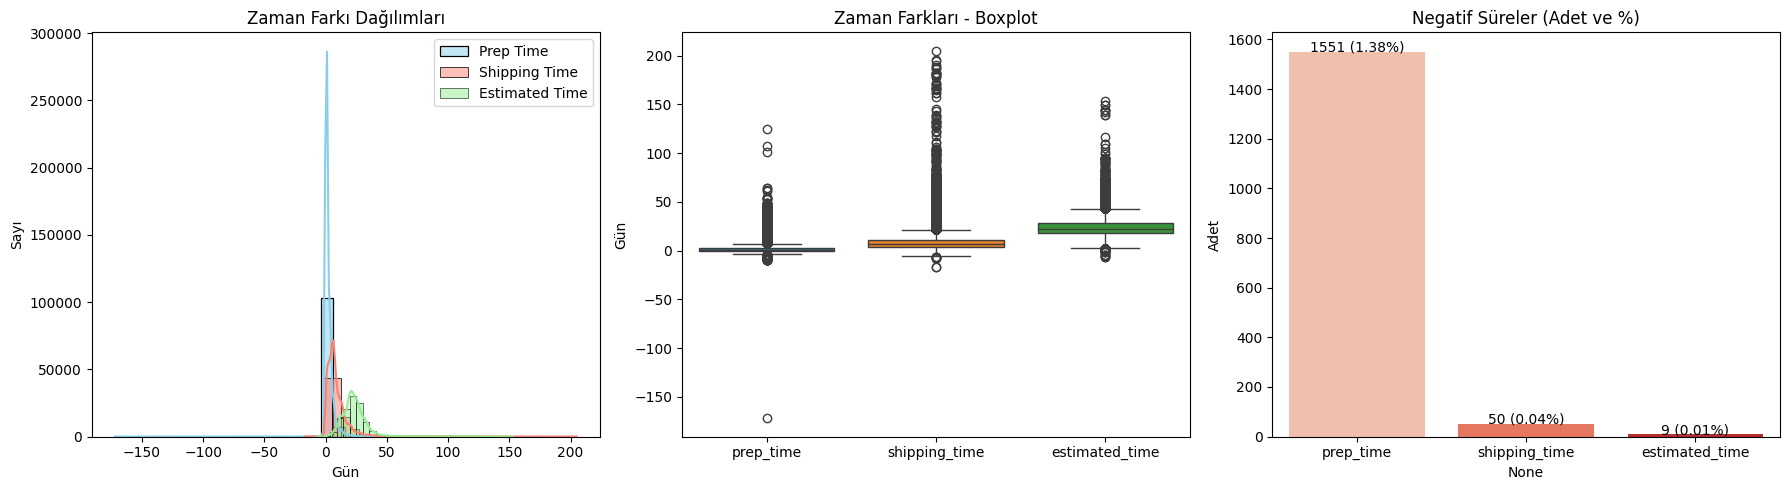

In [46]:
# Toplam satır sayısı
total_rows = fact_DF.shape[0]

# Negatif değerler
neg_counts = fact_DF[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)

# Grafik oluştur
plt.figure(figsize=(18,5))

# --- Histogram ---
plt.subplot(1,3,1)
sns.histplot(fact_DF["prep_time"], kde=True, color="skyblue", label="Prep Time", bins=30)
sns.histplot(fact_DF["shipping_time"], kde=True, color="salmon", label="Shipping Time", bins=30)
sns.histplot(fact_DF["estimated_time"], kde=True, color="lightgreen", label="Estimated Time", bins=30)
plt.title("Zaman Farkı Dağılımları")
plt.xlabel("Gün")
plt.ylabel("Sayı")
plt.legend()

# --- Boxplot ---
plt.subplot(1,3,2)
sns.boxplot(data=fact_DF[["prep_time", "shipping_time", "estimated_time"]])
plt.title("Zaman Farkları - Boxplot")
plt.ylabel("Gün")

# --- Negatif Değerler Barplot ---
plt.subplot(1,3,3)
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negatif Süreler (Adet ve %)")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()

prep_time negatif: sipariş daha onaylanmadan kargoya verilmiş görünüyor (timestamp sorunu olabilir).

shipping_time negatif: müşteri ürünü kargoya verilmeden teslim almış gibi görünüyor (muhtemelen data error).

estimated_time negatif: tahmini teslim tarihi onay tarihinden önce görünüyor (yanlış kayıt).

In [47]:
print(fact_DF.shape[0])
fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100


112650


prep_time        1.073
shipping_time    2.179
estimated_time   0.013
dtype: float64

### Gecikme hesaplamaları ve sınıflandırması

In [48]:
fact_DF['delay_days'] = (fact_DF['order_delivered_customer_date'] - fact_DF['order_estimated_delivery_date']).dt.days
fact_DF['delay_days'] = fact_DF['delay_days'].apply(lambda x: max(0, x))
fact_DF['is_late'] = fact_DF['delay_days'].apply(lambda x: 1 if x > 0 else 0)

In [49]:
# --- Sabit aralıklı Gecikme sınıfı (iş zekâsı için) ---
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_DF['delay_class'] = fact_DF['delay_days'].apply(classify_delay)

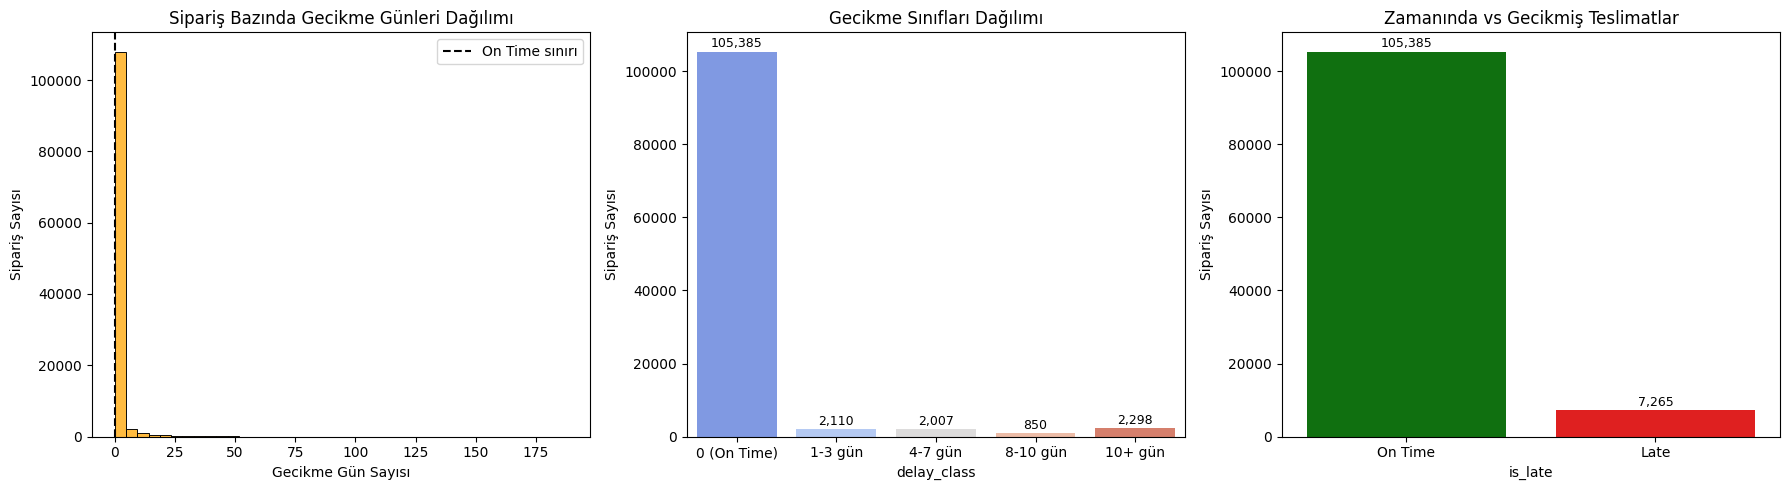

In [50]:
# Toplam satır sayısı
total_rows = fact_DF.shape[0]

# 1. Dağılımlar
delay_class_counts = fact_DF['delay_class'].value_counts().sort_index()
late_counts = fact_DF['is_late'].value_counts()

plt.figure(figsize=(18,5))

# --- 1. Histogram: delay_days ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['delay_days'], bins=40, color='orange', kde=False)
plt.title('Sipariş Bazında Gecikme Günleri Dağılımı')
plt.xlabel('Gecikme Gün Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.axvline(0, color="black", linestyle="--", label="On Time sınırı")
plt.legend()

# --- 2. Barplot: delay_class ---
plt.subplot(1,3,2)
sns.barplot(x=delay_class_counts.index, y=delay_class_counts.values, palette='coolwarm')
plt.xticks([0,1,2,3,4], ['0 (On Time)', '1-3 gün', '4-7 gün', '8-10 gün', '10+ gün'])
for i, v in enumerate(delay_class_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('Gecikme Sınıfları Dağılımı')
plt.ylabel('Sipariş Sayısı')

# --- 3. Barplot: is_late ---
plt.subplot(1,3,3)
sns.barplot(x=late_counts.index, y=late_counts.values, palette=['green','red'])
plt.xticks([0,1], ['On Time', 'Late'])
for i, v in enumerate(late_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('Zamanında vs Gecikmiş Teslimatlar')
plt.ylabel('Sipariş Sayısı')

plt.tight_layout()
plt.show()

###  Mesafe hesaplama ve satıcı sayısı

In [51]:
# haversine, genellikle iki koordinat arasındaki mesafeyi (km veya mil cinsinden) hesaplamak için kullanılır.
fact_DF = fact_DF.rename(columns={
    "lat_avg_x": "customer_lat_avg",
    "lng_avg_x": "customer_lng_avg",
    "lat_avg_y": "seller_lat_avg",
    "lng_avg_y": "seller_lng_avg"
})

# Haversine ile mesafe hesapla
def compute_distance(row):
    return haversine(
        (row['customer_lat_avg'], row['customer_lng_avg']), 
        (row['seller_lat_avg'], row['seller_lng_avg'])
    )

fact_DF['distance_km'] = fact_DF.apply(compute_distance, axis=1)

In [52]:
#  Aynı siparişteki satıcı sayısı
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)
fact_DF = fact_DF.merge(seller_count, on='order_id_pref', how='left')

In [53]:
#  İlgili sütunları seçerek final fact tablosu
fact_order_shipments = fact_DF[[
    'cusUni','customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_types', 'payment_value_sum', 'payment_installments_max',
    'seller_count_per_order'
]]


fact_order_shipments.to_csv('fact_order_shipments.csv', index=False) # csv olarak kaydet. 

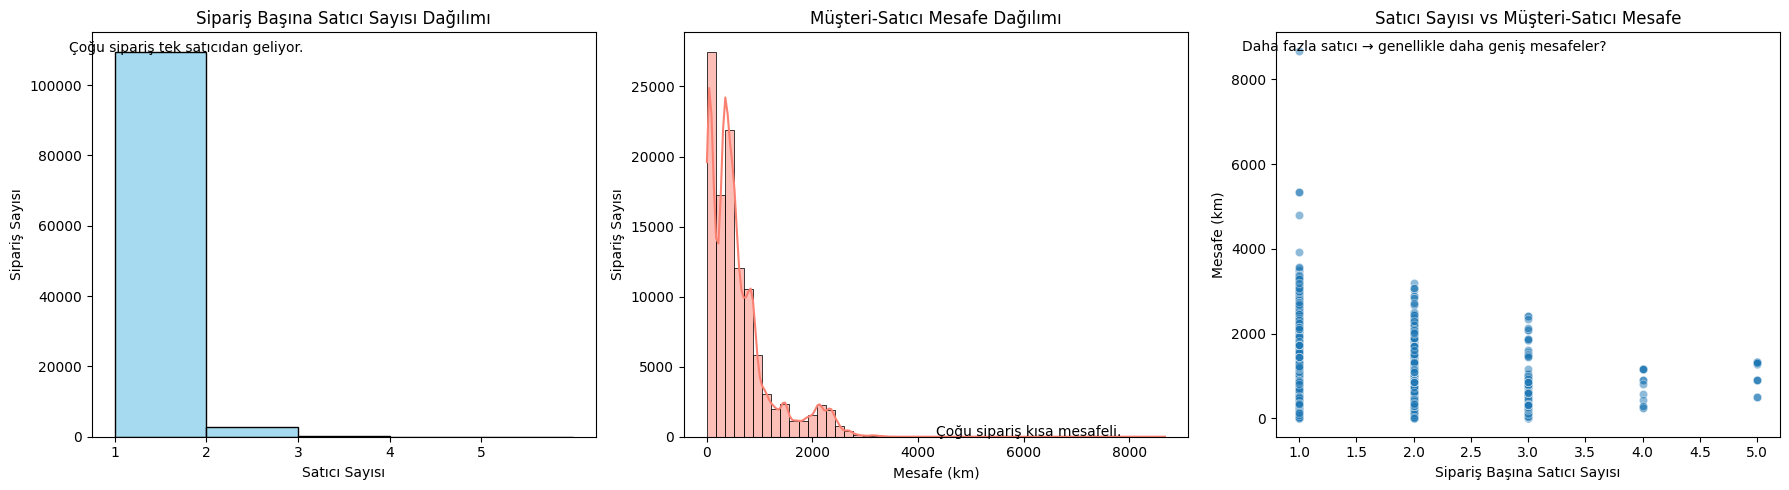

In [54]:
plt.figure(figsize=(18,5))

# --- 1. Histogram: seller_count_per_order ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['seller_count_per_order'], bins=range(1, fact_DF['seller_count_per_order'].max()+2), 
             color='skyblue', kde=False)
plt.title('Sipariş Başına Satıcı Sayısı Dağılımı')
plt.xlabel('Satıcı Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.xticks(range(1, fact_DF['seller_count_per_order'].max()+1))
plt.text(0.5, max(fact_DF['seller_count_per_order'].value_counts()), 
         "Çoğu sipariş tek satıcıdan geliyor.", fontsize=10, color='black')

# --- 2. Histogram: distance_km ---
plt.subplot(1,3,2)
sns.histplot(fact_DF['distance_km'], bins=50, color='salmon', kde=True)
plt.title('Müşteri-Satıcı Mesafe Dağılımı')
plt.xlabel('Mesafe (km)')
plt.ylabel('Sipariş Sayısı')
plt.text(max(fact_DF['distance_km'])/2, max(fact_DF['distance_km'].value_counts()), 
         "Çoğu sipariş kısa mesafeli.", fontsize=10, color='black')

# --- 3. Scatter Plot: seller_count_per_order vs distance_km ---
plt.subplot(1,3,3)
sns.scatterplot(x='seller_count_per_order', y='distance_km', data=fact_DF, alpha=0.5)
plt.title('Satıcı Sayısı vs Müşteri-Satıcı Mesafe')
plt.xlabel('Sipariş Başına Satıcı Sayısı')
plt.ylabel('Mesafe (km)')
plt.text(0.5, max(fact_DF['distance_km']), 
         "Daha fazla satıcı → genellikle daha geniş mesafeler?", fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Null ve negatif değer kontrolü

Toplam satır sayısı: 112,650

Negatif süreler (adet ve %):
  prep_time      : 1551  (1.38%)
  shipping_time  : 50  (0.04%)
  estimated_time : 9  (0.01%)


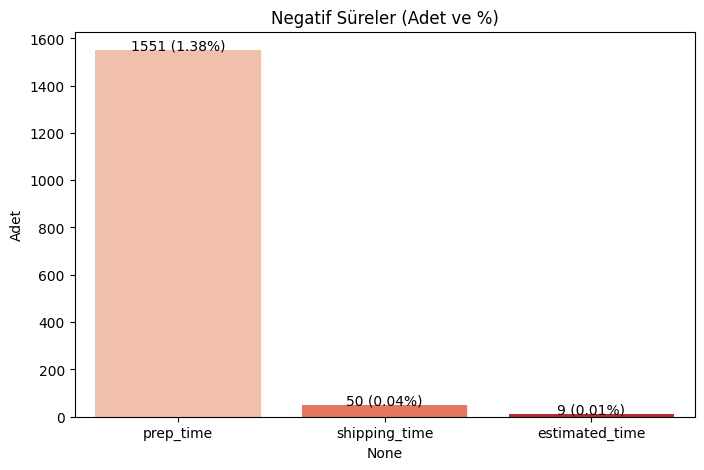


Null değerler (adet ve %):
  prep_time      : 1209  (1.07%)
  shipping_time  : 2455  (2.18%)
  estimated_time : 15  (0.01%)
  delay_days     : 0  (0.0%)
  distance_km    : 554  (0.49%)


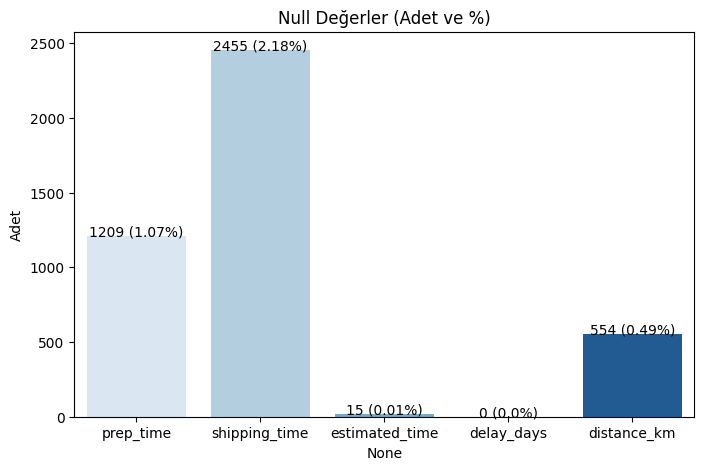

In [55]:
total_rows = fact_order_shipments.shape[0]

print(f"Toplam satır sayısı: {total_rows:,}\n")

# --- Negatif süreler ---
neg_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)
print("Negatif süreler (adet ve %):")
for col in neg_counts.index:
    print(f"  {col:<15}: {neg_counts[col]}  ({neg_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negatif Süreler (Adet ve %)")
plt.ylabel("Adet")
plt.show()

# --- Null değerler ---
null_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time","delay_days","distance_km"]].isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nNull değerler (adet ve %):")
for col in null_counts.index:
    print(f"  {col:<15}: {null_counts[col]}  ({null_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=null_counts.index, y=null_counts.values, palette="Blues")
for i, v in enumerate(null_counts.values):
    plt.text(i, v + 1, f"{v} ({null_perc[i]}%)", ha='center')
plt.title("Null Değerler (Adet ve %)")
plt.ylabel("Adet")
plt.show()



### Özet istatistikler / Temel sayısal özetler ve tipler

In [56]:
# --- Gecikme oranı ---
late_count = fact_order_shipments["is_late"].sum()
late_perc  = (late_count / total_rows * 100).round(2)
print(f"\nGecikmeli siparişler: {late_count}  ({late_perc}%)")

# --- Ödeme türleri ---
print("\nÖdeme türleri (adet ve % - ilk 10):")
pay_counts = fact_order_shipments["payment_types"].value_counts()
for t, c in pay_counts.head(10).items():
    print(f"  {t:<25}: {c}  ({c/total_rows*100:.2f}%)")

# --- Satıcı sayısı ---
print("\nSiparişteki satıcı sayısı (adet ve %):")
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
for sc, c in seller_counts.items():
    print(f"  {sc:<2} satıcı: {c}  ({c/total_rows*100:.2f}%)")


Gecikmeli siparişler: 7265  (6.45%)

Ödeme türleri (adet ve % - ilk 10):
  credit_card              : 83947  (74.52%)
  boleto                   : 22867  (20.30%)
  credit_card/voucher      : 2487  (2.21%)
  debit_card               : 1689  (1.50%)
  voucher                  : 1656  (1.47%)
  credit_card/debit_card   : 1  (0.00%)

Siparişteki satıcı sayısı (adet ve %):
  1  satıcı: 109547  (97.25%)
  2  satıcı: 2876  (2.55%)
  3  satıcı: 202  (0.18%)
  4  satıcı: 12  (0.01%)
  5  satıcı: 13  (0.01%)


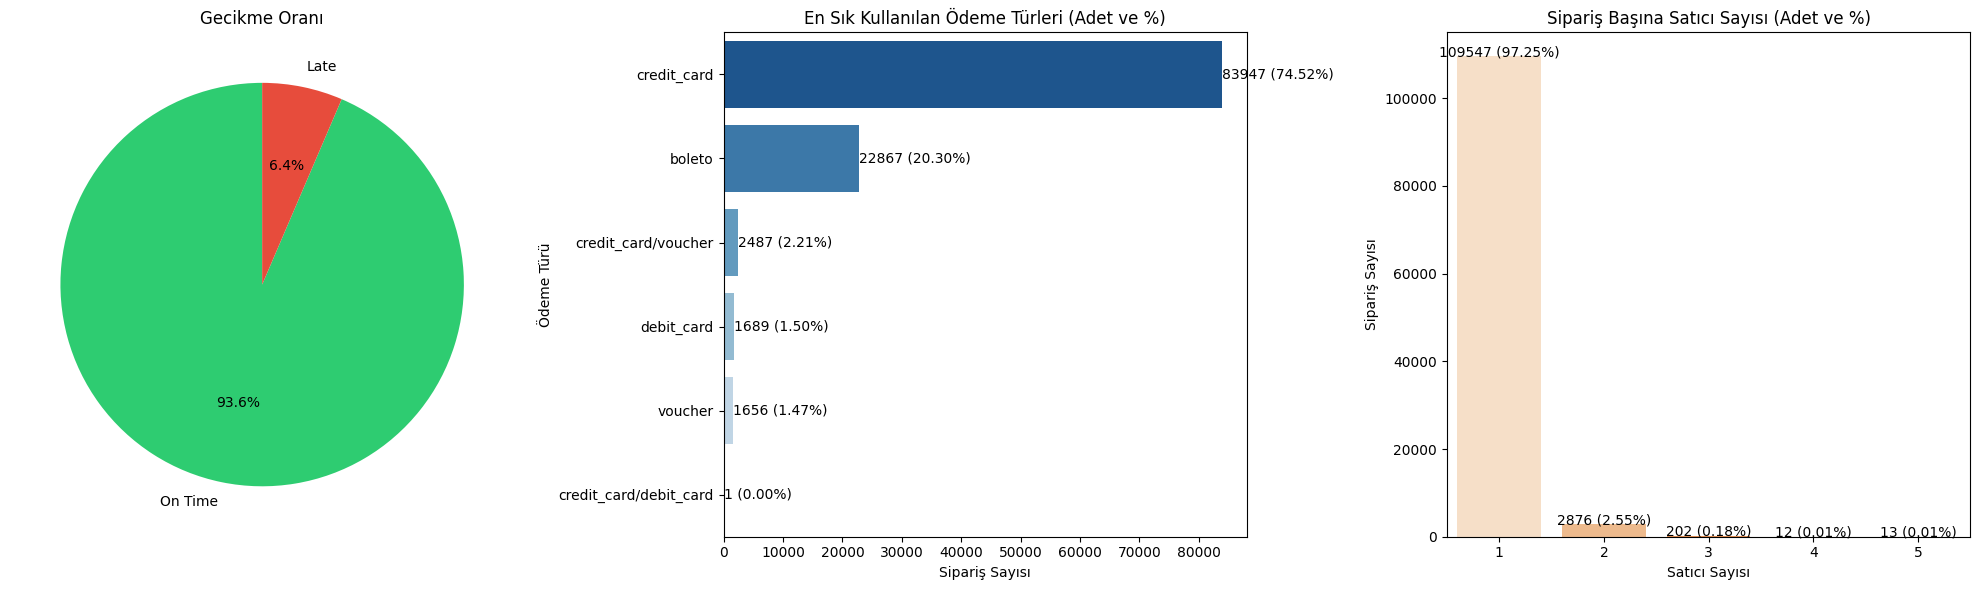

In [57]:
plt.figure(figsize=(20,6))

# --- 1. Gecikme Oranı Pie Chart ---
plt.subplot(1,3,1)
late_counts = fact_order_shipments['is_late'].value_counts()
plt.pie(late_counts.values, labels=['On Time', 'Late'], autopct='%1.1f%%', colors=['#2ecc71','#e74c3c'], startangle=90)
plt.title('Gecikme Oranı')

# --- 2. Ödeme Türleri Barplot ---
plt.subplot(1,3,2)
pay_counts = fact_order_shipments["payment_types"].value_counts().head(10)  # İlk 10 ödeme türü
sns.barplot(x=pay_counts.values, y=pay_counts.index, palette='Blues_r')
for i, v in enumerate(pay_counts.values):
    plt.text(v + 5, i, f"{v} ({v/total_rows*100:.2f}%)", va='center')
plt.title('En Sık Kullanılan Ödeme Türleri (Adet ve %)')
plt.xlabel('Sipariş Sayısı')
plt.ylabel('Ödeme Türü')

# --- 3. Satıcı Sayısı Barplot ---
plt.subplot(1,3,3)
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='Oranges')
for i, v in enumerate(seller_counts.values):
    plt.text(i, v + 5, f"{v} ({v/total_rows*100:.2f}%)", ha='center')
plt.title('Sipariş Başına Satıcı Sayısı (Adet ve %)')
plt.xlabel('Satıcı Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.xticks(range(len(seller_counts.index)), seller_counts.index)

plt.tight_layout()
plt.show()


Oluşturduğumuz data frame'in yeni kolonları, kolonların anlamları ve Modele yapacağı katkıyı gösterecek tablo aşağıdadır. 

| Kolon                   | Anlamı                                           | Katkısı (Model İçin)                                                                 |
|--------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------|
| customer_id_pref         | Her müşteri için benzersiz kimlik                | Müşteri davranışları (ör. aynı satıcıdan/bölgeden alışveriş) teslimatı etkileyebilir. |
| order_id_pref            | Her sipariş için benzersiz kimlik                | Sipariş bazlı modelleme için gerekli. Gecikme sürelerini hesaplamakta kullanılır.     |
| seller_id_pref           | Satıcının kimliği                                | Satıcı performansı gecikmeyi etkileyebilir. Bazı satıcılar daha hızlı/yavaş olabilir. |
| product_id_pref          | Ürün kimliği                                     | Ürün boyutu, stok durumu veya paketleme süresi gecikmeyi etkileyebilir.               |
| order_purchase_timestamp | Siparişin verildiği tarih                        | Sezon, hafta içi/sonu, tatil günleri gibi zamansal faktörler gecikmeyi etkiler.       |
| order_approved_at        | Siparişin onay tarihi                            | Onay–kargoya verme farkı (prep_time) için gerekli. Hazırlık süresini model öğrenebilir. |
| order_delivered_carrier_date | Siparişin kargoya verildiği tarih            | Kargo şirketi performansını ölçmek için kullanılabilir.                               |
| order_delivered_customer_date | Gerçek teslim tarihi                        | Hedef değişkenin hesaplanmasında kullanılır (delay_days, is_late).                    |
| order_estimated_delivery_date | Tahmini teslim tarihi                       | Gecikmenin hesaplanmasında referans alınır.                                           |
| prep_time                | Onay–kargoya verme süresi                        | Hazırlık süresi gecikme tahmininde önemli bir feature’dır.                            |
| shipping_time            | Kargo–teslim süresi                              | Teslimat gecikmesini doğrudan etkiler, kritik bir feature’dır.                        |
| estimated_time           | Onay–tahmini teslim süresi                       | Gerçek süre ile kıyaslanarak gecikme tahmininde kullanılır.                           |
| delay_days               | Tahmini–gerçek teslim farkı (gün)                | Sayısal hedef değişken (regresyon) olarak kullanılabilir.                             |
| delay_class              | Gecikme sınıfı (0: zamanında, 1: 1–3 gün, …)     | Çok sınıflı sınıflandırma hedefi olarak kullanılabilir.                               |
| is_late                  | Gecikme bayrağı (0/1)                            | İkili sınıflandırma hedefi (binary classification) olarak kullanılabilir.             |
| distance_km              | Müşteri–satıcı mesafesi                          | Mesafe arttıkça gecikme olasılığı artabilir; coğrafi etkiyi modele katar.             |
| payment_types            | Kullanılan ödeme tür(ler)i                       | Bazı ödeme tiplerinde onay süresi daha uzun olabilir, dolaylı etki yaratabilir.       |
| payment_value_sum        | Toplam ödeme tutarı                              | Yüksek değerli siparişler daha hızlı işlenebilir; model bunu öğrenebilir.             |
| payment_installments_max | Maksimum taksit sayısı                           | Taksitli alışverişlerde ödeme onayı gecikebilir.                                      |
| seller_count_per_order   | Siparişteki satıcı sayısı                        | Çok satıcılı siparişlerde gecikme olasılığı daha yüksek olabilir.                     |


In [58]:
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [59]:
# Toplam satır sayısı
total_orders = fact_DF.shape[0]

# Gecikmeli sipariş sayısı
total_late_orders = fact_DF["is_late"].sum()

# Oran (%)
late_ratio = (total_late_orders / total_orders) * 100

print(f"Toplam sipariş sayısı: {total_orders:,}")
print(f"Gecikmeli sipariş sayısı: {total_late_orders:,}  ({late_ratio:.2f}%)")

Toplam sipariş sayısı: 112,650
Gecikmeli sipariş sayısı: 7,265  (6.45%)


In [60]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]

# delay_days ? (0'dan büyük olanlar gecikmeli)
late_orders = fact_DF[fact_DF['delay_days'] > 0]
late_orders.head()


,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_sum,payment_installments_max,payment_types,prep_time,shipping_time,estimated_time,delay_days,is_late,delay_class,distance_km,seller_count_per_order
21,OIT022,ORD35003,PRO7116,SEL988,1,2017-11-27 19:09:02,21.990,11.850,CUS64044,delivered,2017-11-21 18:54:23,2017-11-21 19:09:02,2017-11-22 20:46:54,2017-12-09 17:27:23,2017-12-07,18900,santacruzdoriopardo,SP,CUSUNI62617,-22.896,-49.624,4160,saopaulo,SP,-23.625,-46.612,telefonia,59.000,540.000,4.000,300.000,17.000,4.000,12.000,33.840,3.000,credit_card,1.000,16.000,15.000,2.000,1,1,318.214,1
39,OIT040,ORD71320,PRO20794,SEL1264,1,2017-04-24 22:25:19,809.100,44.290,CUS27545,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,2017-04-17 13:54:37,2017-05-23 08:32:07,2017-05-19,57250,campoalegre,AL,CUSUNI6726,-9.784,-36.350,35680,itauna,MG,-20.078,-44.576,informatica_acessorios,60.000,2136.000,1.000,3407.000,28.000,22.000,23.000,853.390,10.000,credit_card,10.000,35.000,42.000,4.000,1,2,1445.199,1
47,OIT048,ORD2491,PRO21689,SEL2464,1,2017-11-29 22:38:47,99.000,13.710,CUS507,delivered,2017-11-24 19:19:18,2017-11-24 22:38:47,2017-11-27 12:42:15,2017-12-22 18:37:40,2017-12-14,8072,saopaulo,SP,CUSUNI0507,-23.512,-46.484,14940,ibitinga,SP,-21.757,-48.830,cama_mesa_banho,55.000,312.000,1.000,1550.000,44.000,14.000,34.000,112.710,4.000,credit_card,2.000,25.000,19.000,8.000,1,3,309.811,1
48,OIT049,ORD42206,PRO20437,SEL2364,1,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1
49,OIT050,ORD42206,PRO20437,SEL2364,2,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1


Grup 1 – Veri Hazırlık & Temel İnceleme

* 1.1. Fact tablosunu yükle ve ilk birkaç satırı göster
* 1.2. Veri tiplerini kontrol et, tarih kolonlarını datetime formatına çevir
* 1.3. Eksik değerleri kontrol et
* 1.4. Toplam kayıt sayısını bul
* 1.5. Tekil müşteri / satıcı / sipariş sayılarını kontrol et
* 1.6. Sayısal kolonları özetle (prep_time, shipping_time, estimated_time, delay_days, payment_value_sum)

### === GRUP 1: Veri Hazırlık & Temel İnceleme ===

In [61]:
# 1.1 Fact tablo ilk 5 satır
fact_DF.head()

# 1.2 Veri tipleri + tarih dönüşümleri
fact_DF.dtypes
date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_customer_date","order_estimated_delivery_date"
]
fact_DF[date_cols] = fact_DF[date_cols].apply(pd.to_datetime, errors="coerce")

# 1.3 Eksik değer kontrolü (adet ve %)
total_rows = fact_DF.shape[0]
null_counts = fact_DF.isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nEksik değerler (adet ve %):")
for col in null_counts.index:
    if null_counts[col] > 0:
        print(f"{col:<35}: {null_counts[col]}  ({null_perc[col]}%)")

# 1.4 Toplam kayıt sayısı
print("\nToplam kayıt sayısı:", total_rows)

# 1.5 Tekil müşteri / satıcı / sipariş sayıları (adet ve %)
cust_count   = fact_DF["cusUni"].nunique()
seller_count = fact_DF["seller_id_pref"].nunique()
order_count  = fact_DF["order_id_pref"].nunique()

print(f"\nTekil müşteri sayısı : {cust_count}")
print(f"Tekil satıcı sayısı  : {seller_count}")
print(f"Tekil sipariş sayısı : {order_count}")

# 1.6 Sayısal kolonları özetle
num_cols = ["prep_time","shipping_time","estimated_time","delay_days","payment_value_sum"]
print("\nSayısal kolonların özeti:")
fact_DF[num_cols].describe().T
fact_DF[num_cols].quantile([0.01, 0.99])


Eksik değerler (adet ve %):
order_approved_at                  : 15  (0.01%)
order_delivered_carrier_date       : 1194  (1.06%)
order_delivered_customer_date      : 2454  (2.18%)
customer_lat_avg                   : 302  (0.27%)
customer_lng_avg                   : 302  (0.27%)
seller_lat_avg                     : 253  (0.22%)
seller_lng_avg                     : 253  (0.22%)
product_category_name              : 1603  (1.42%)
product_name_lenght                : 1603  (1.42%)
product_description_lenght         : 1603  (1.42%)
product_photos_qty                 : 1603  (1.42%)
product_weight_g                   : 18  (0.02%)
product_length_cm                  : 18  (0.02%)
product_height_cm                  : 18  (0.02%)
product_width_cm                   : 18  (0.02%)
payment_value_sum                  : 3  (0.0%)
payment_installments_max           : 3  (0.0%)
payment_types                      : 3  (0.0%)
prep_time                          : 1209  (1.07%)
shipping_time               

,prep_time,shipping_time,estimated_time,delay_days,payment_value_sum
0.010,-1.000,0.000,5.000,0.000,22.950
0.990,17.000,40.000,50.000,18.000,1238.960


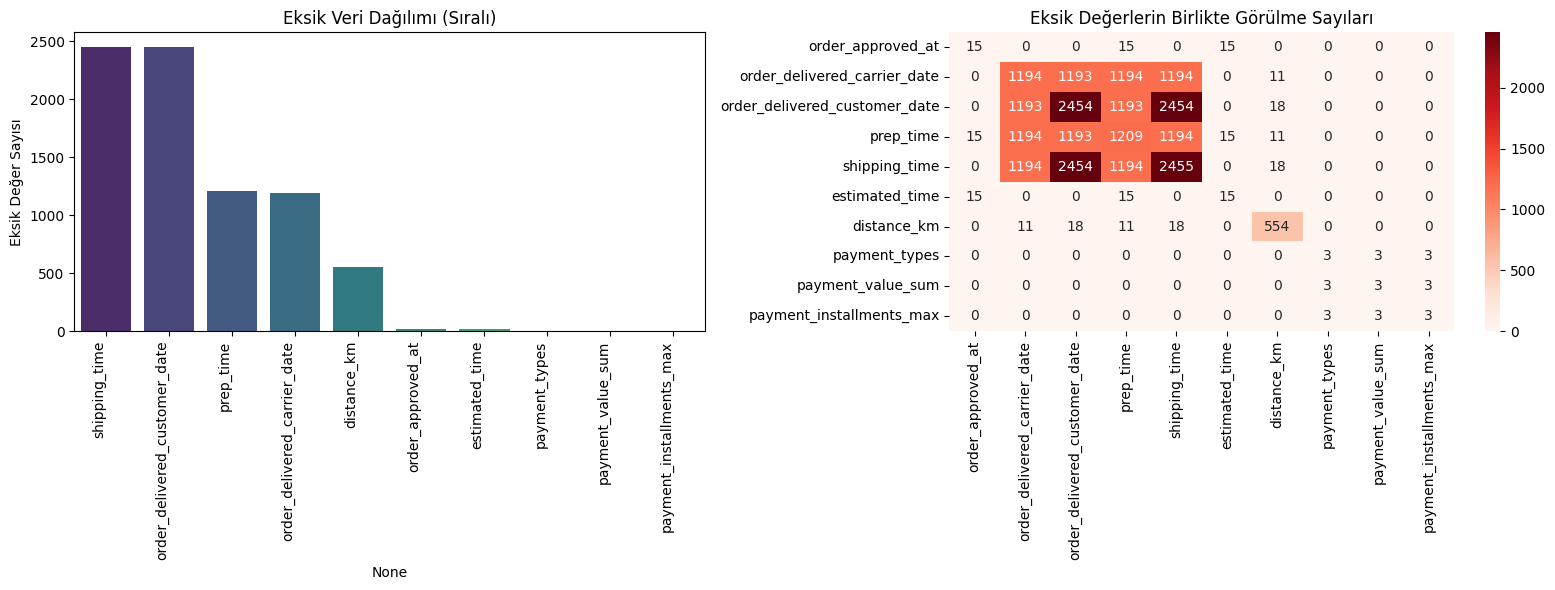

Toplam eksik hücre sayısı       : 7905
Üç kolonun oluşturduğu eksik hücre sayısı: 6102 (%77.19)
Drop edilirse satır kaybı       : 2454 (%2.18)


In [62]:
# --- Eksik değerler analizi (Barplot + Heatmap + Sayısal) ---

missing_cols = fact_order_shipments.columns[fact_order_shipments.isna().any()].tolist()

# Eksik sayıları hesapla ve sırala
null_counts = fact_order_shipments[missing_cols].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(16,6))

# --- 1. Barplot (büyükten küçüğe sıralı) ---
plt.subplot(1,2,1)
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")
plt.xticks(rotation=90, ha="right")
plt.ylabel("Eksik Değer Sayısı")
plt.title("Eksik Veri Dağılımı (Sıralı)")

# --- 2. Heatmap ---
plt.subplot(1,2,2)
mask_int = fact_order_shipments[missing_cols].isna().astype(int)
missing_overlap = mask_int.T.dot(mask_int)
sns.heatmap(missing_overlap, annot=True, fmt="d", cmap="Reds")
plt.title("Eksik Değerlerin Birlikte Görülme Sayıları")

plt.tight_layout()
plt.show()

# --- 3. Sayısal özet ---
total_missing = fact_order_shipments.isna().sum().sum()
total_rows = len(fact_order_shipments)

deliv_missing = fact_order_shipments["order_delivered_customer_date"].isna().sum()
ship_missing  = fact_order_shipments["shipping_time"].isna().sum()
prep_overlap  = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna() &
    fact_order_shipments["prep_time"].isna()
].shape[0]

total_overlap_cells = deliv_missing + ship_missing + prep_overlap
pct_overlap = round(total_overlap_cells / total_missing * 100, 2)
row_loss_pct = round(deliv_missing / total_rows * 100, 2)

print(f"Toplam eksik hücre sayısı       : {total_missing}")
print(f"Üç kolonun oluşturduğu eksik hücre sayısı: {total_overlap_cells} (%{pct_overlap})")
print(f"Drop edilirse satır kaybı       : {deliv_missing} (%{row_loss_pct})")

Bu siparişlerin tarihi de analizimiz için önemlidir. Çünkü eğer tarihsel dağılımı son günlere rastgeliyorsa, bu eksikler henüz tamamlanma aşamasında olan siparişlerden oluşuyor olabilir. öyle bir durumda makine öğrenmesi için test olarak kullanılabilir. şimdi zamana göre dağılımını gösterelim. 

Teslim edilmeyen siparişlerin tarih aralığı:
Min: 2016-09-04 21:15:19
Max: 2018-09-03 09:06:57

Aylık dağılım:
order_purchase_timestamp
2016-09      3
2016-10     44
2017-01     42
2017-02     93
2017-03    103
2017-04    115
2017-05    133
2017-06     94
2017-07    103
2017-08    113
2017-09     94
2017-10    108
2017-11    191
2017-12    121
2018-01    171
2018-02    153
2018-03    200
2018-04    148
2018-05    115
2018-06     71
2018-07    132
2018-08    106
2018-09      1
Freq: M, Name: count, dtype: int64


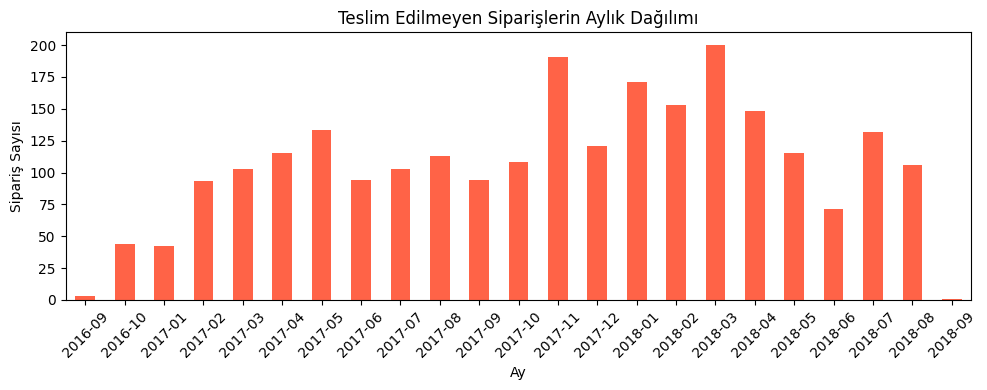

In [63]:
# Teslim edilmeyen siparişlerin satın alma tarihleri
undelivered = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna()
]

date_dist = pd.to_datetime(undelivered["order_purchase_timestamp"])

print("Teslim edilmeyen siparişlerin tarih aralığı:")
print("Min:", date_dist.min())
print("Max:", date_dist.max())

# Ay bazında dağılım
undelivered_by_month = date_dist.dt.to_period("M").value_counts().sort_index()

print("\nAylık dağılım:")
print(undelivered_by_month)

# Görselleştirme
plt.figure(figsize=(10,4))
undelivered_by_month.plot(kind="bar", color="tomato")
plt.title("Teslim Edilmeyen Siparişlerin Aylık Dağılımı")
plt.xlabel("Ay")
plt.ylabel("Sipariş Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Grafikte görüldüğü üzere son zamanlara doğru artan bir teslim edilmeme sorunu yok. Aksine zaman içinde değişik sayılarda teslim edimeyen siparişler bulunmaktadır. Dolayısıyla bu değerler gerçekten eksik değer olarak varsayılacaktır. 

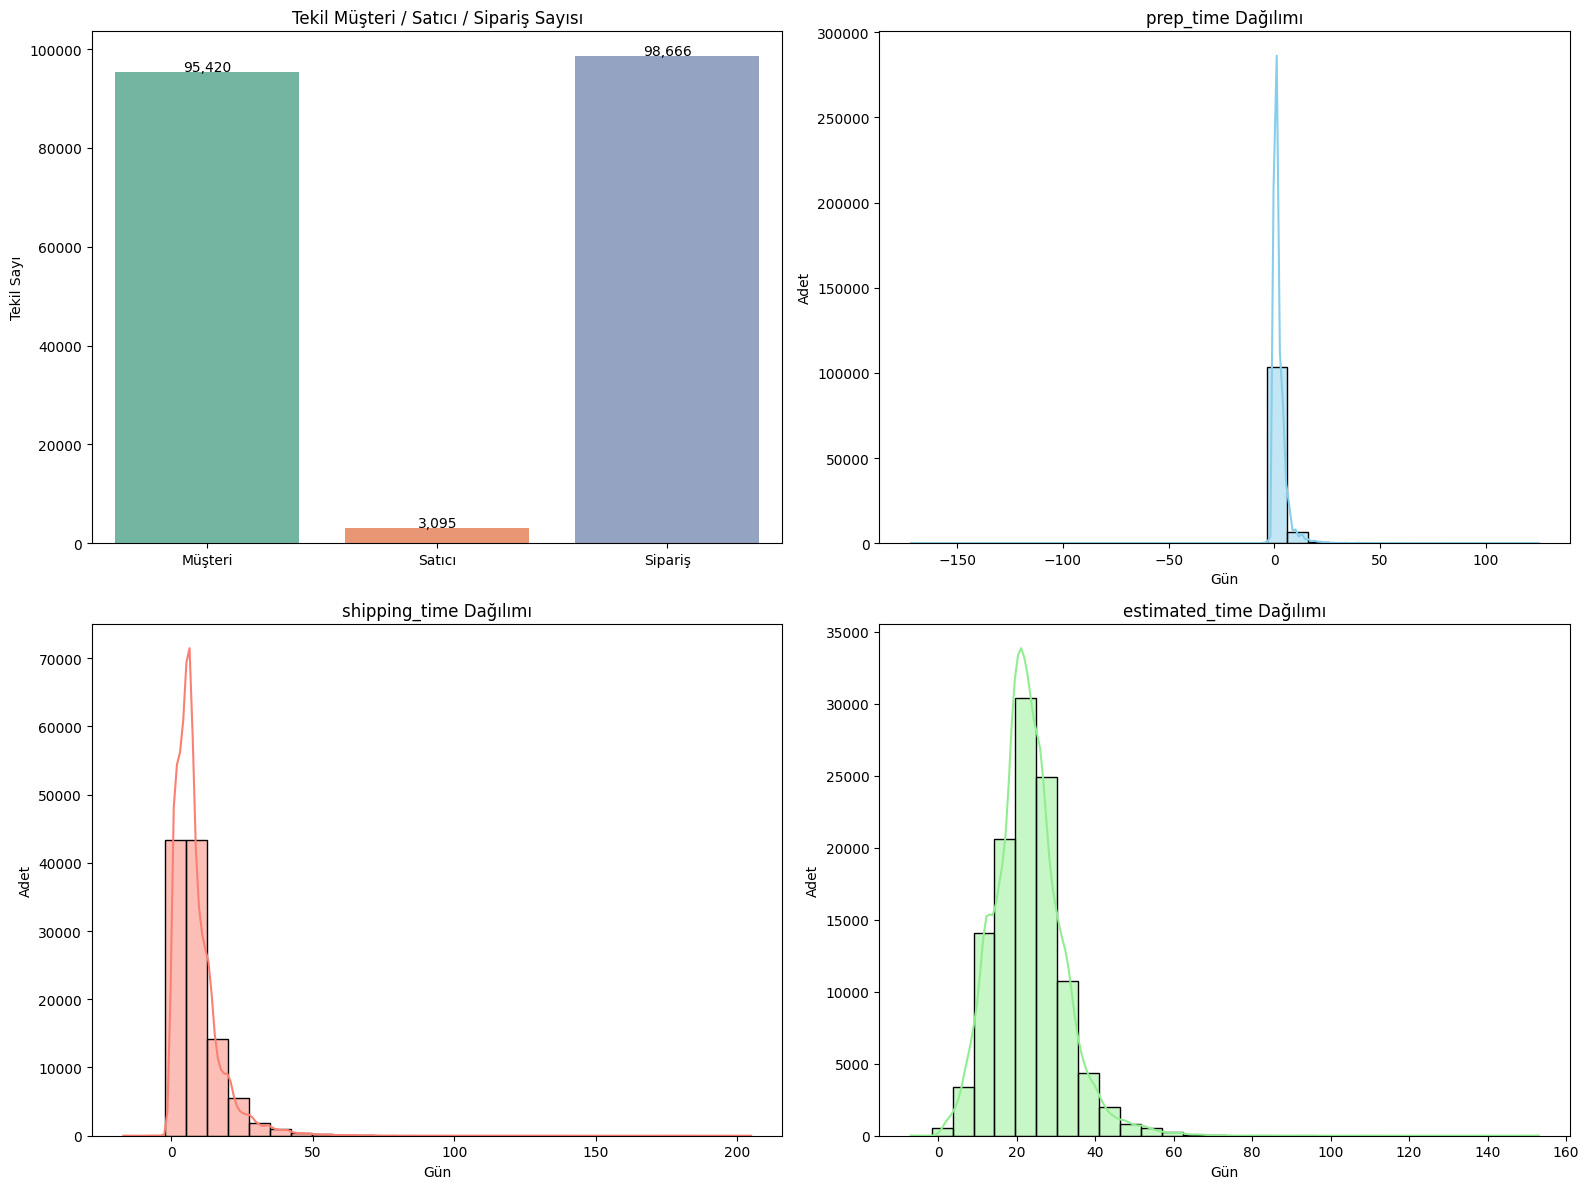

In [64]:
plt.figure(figsize=(16,12))

# --- 1. Tekil müşteri/satıcı/sipariş ---
plt.subplot(2,2,1)
sns.barplot(x=["Müşteri","Satıcı","Sipariş"], y=[cust_count,seller_count,order_count], palette="Set2")
plt.ylabel("Tekil Sayı")
plt.title("Tekil Müşteri / Satıcı / Sipariş Sayısı")
for i, v in enumerate([cust_count,seller_count,order_count]):
    plt.text(i, v + 100, f"{v:,}", ha='center')

# --- 2. prep_time ---
plt.subplot(2,2,2)
sns.histplot(fact_DF["prep_time"], kde=True, bins=30, color="skyblue")
plt.title("prep_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

# --- 3. shipping_time ---
plt.subplot(2,2,3)
sns.histplot(fact_DF["shipping_time"], kde=True, bins=30, color="salmon")
plt.title("shipping_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

# --- 4. estimated_time ---
plt.subplot(2,2,4)
sns.histplot(fact_DF["estimated_time"], kde=True, bins=30, color="lightgreen")
plt.title("estimated_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()

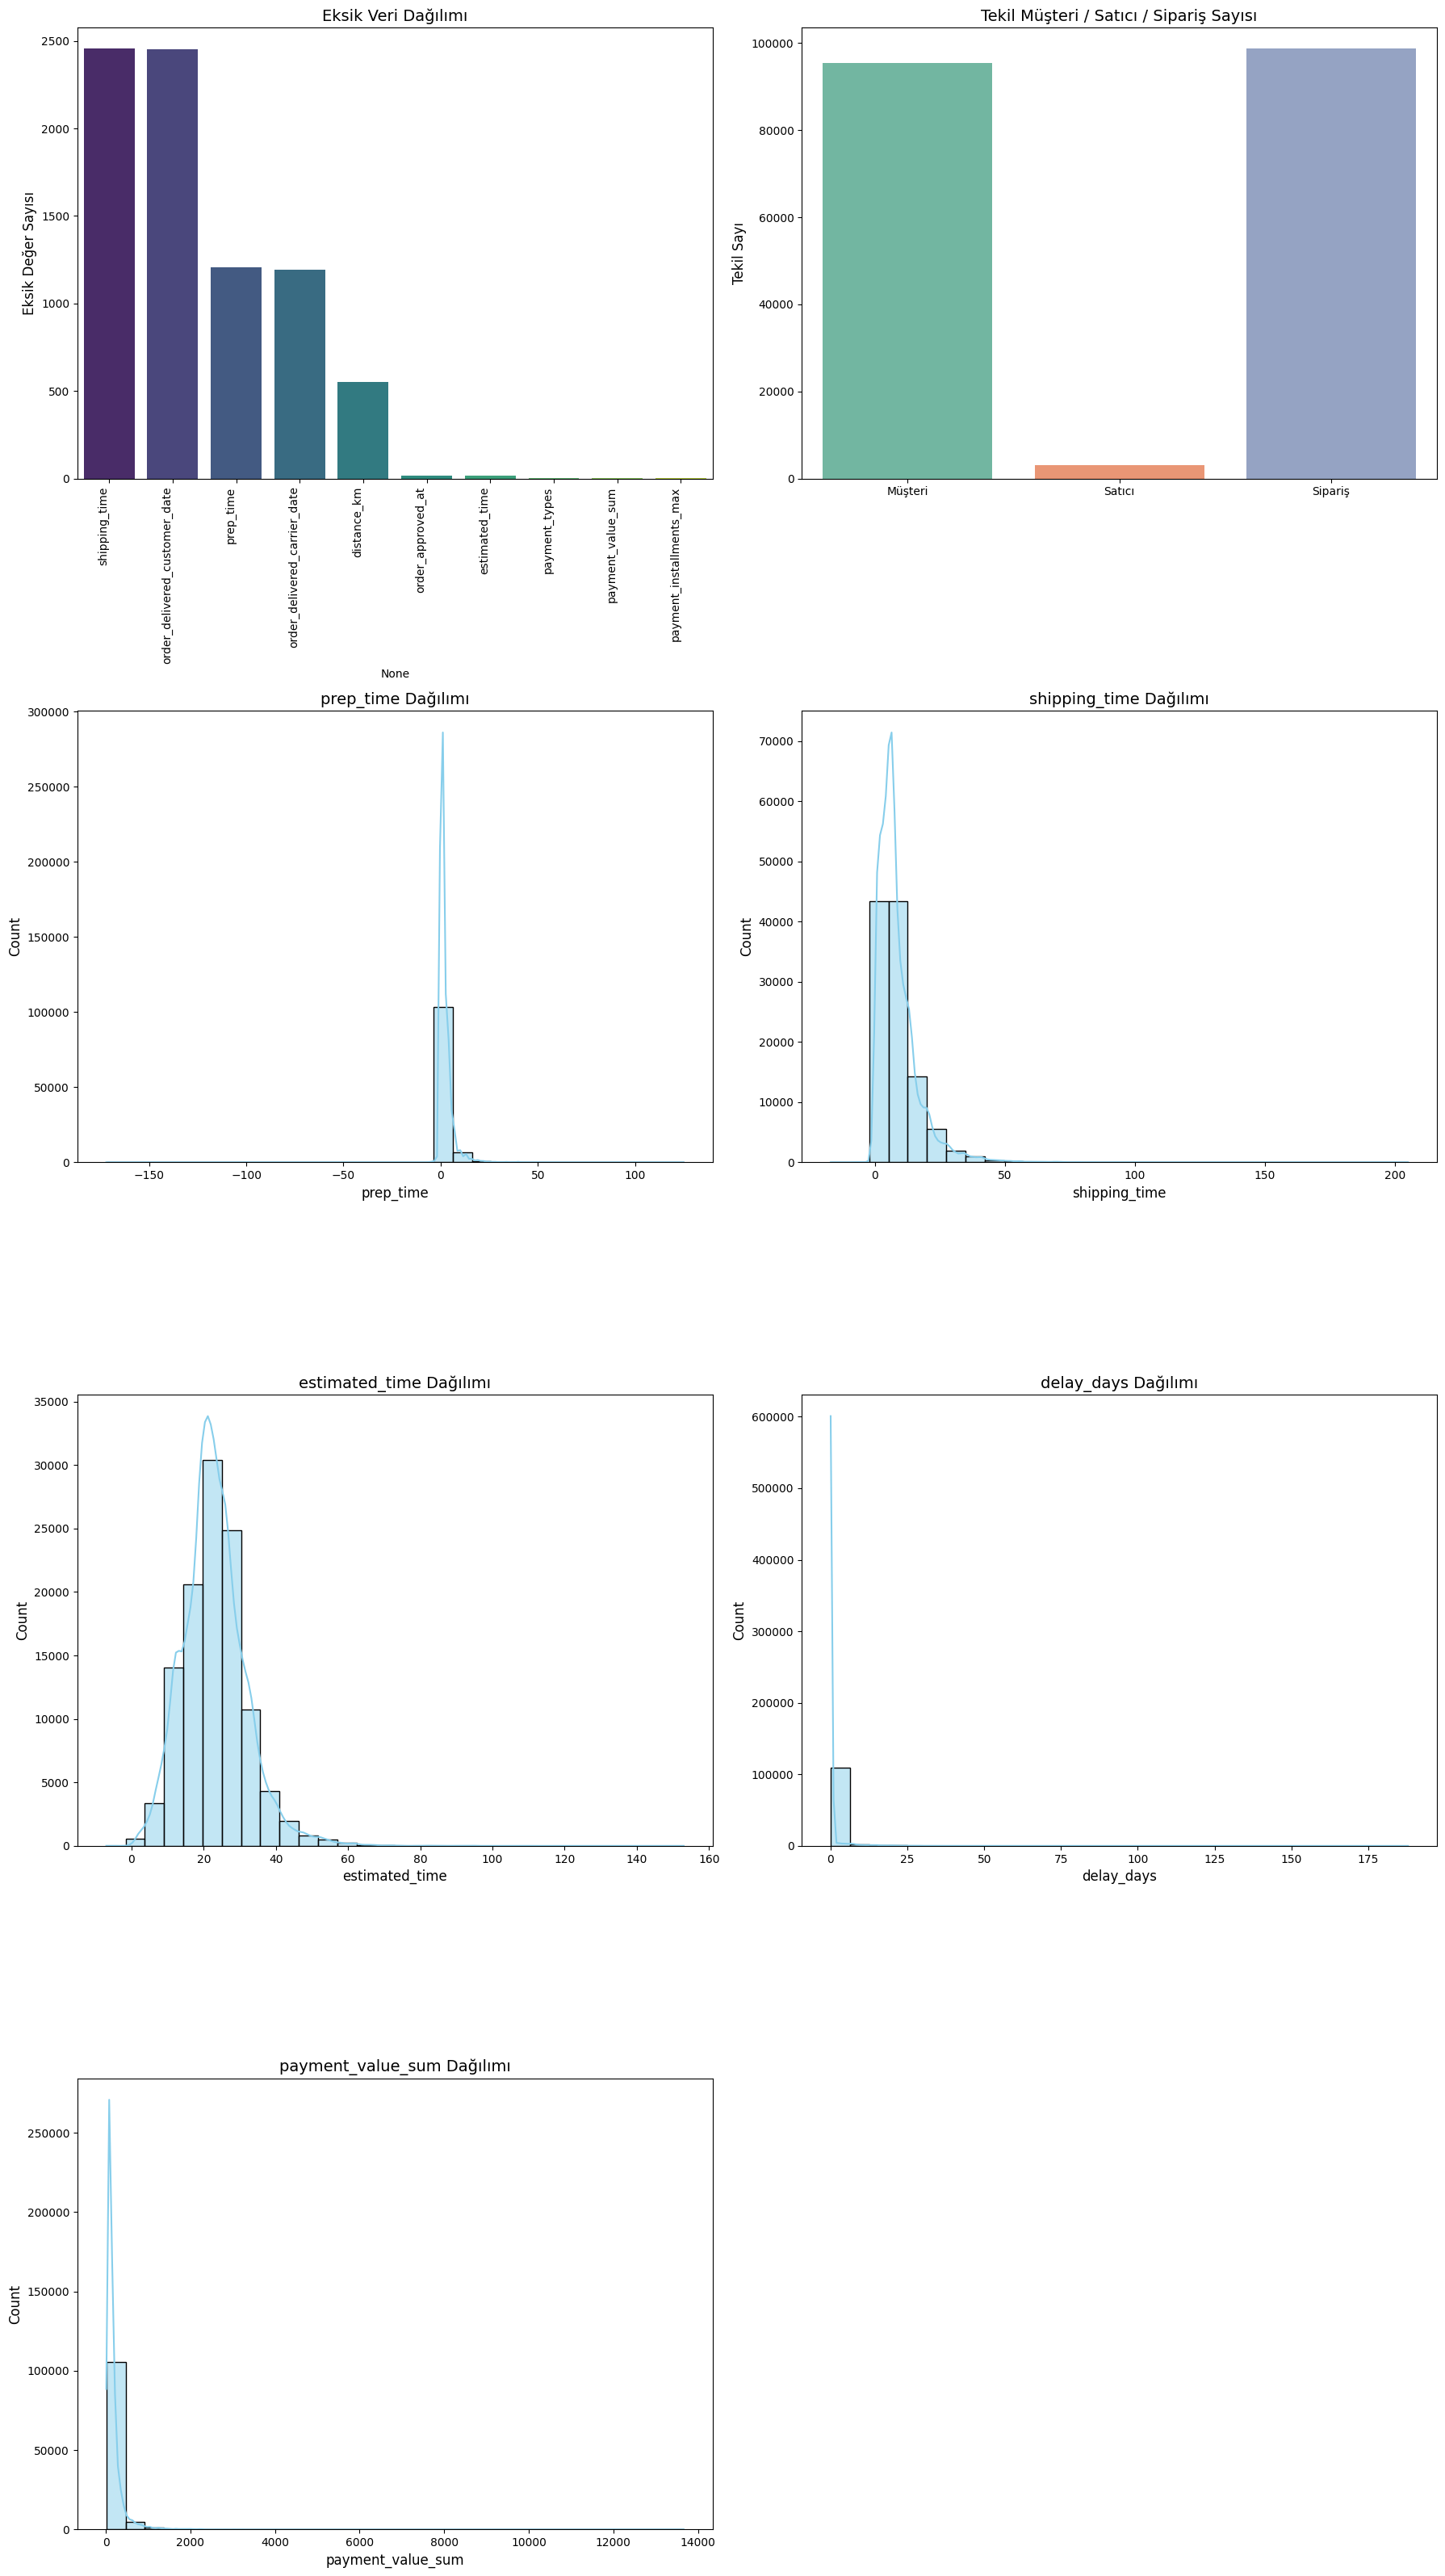

In [65]:
# Kaç tane grafik var? (1 eksik veri + 1 tekil sayılar + numeric kolonlar)
total_plots = 2 + len(num_cols)

# Satır başına 2 grafik olsun
cols = 2
rows = (total_plots + 1) // cols   # kaç satır lazım hesapla

fig, axes = plt.subplots(rows, cols, figsize=(18, rows*8))  # her satır 6 birim yüksek
axes = axes.flatten()

# --- 1. Eksik veri ---
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis", ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha="right", fontsize=10)
axes[0].set_ylabel("Eksik Değer Sayısı", fontsize=12)
axes[0].set_title("Eksik Veri Dağılımı", fontsize=14)

# --- 2. Tekil müşteri/satıcı/sipariş ---
sns.barplot(x=["Müşteri","Satıcı","Sipariş"], y=[cust_count,seller_count,order_count], palette="Set2", ax=axes[1])
axes[1].set_ylabel("Tekil Sayı", fontsize=12)
axes[1].set_title("Tekil Müşteri / Satıcı / Sipariş Sayısı", fontsize=14)

# --- 3+. Sayısal kolonların dağılımları ---
for i, col in enumerate(num_cols):
    sns.histplot(fact_DF[col], kde=True, color="skyblue", bins=30, ax=axes[i+2])
    axes[i+2].set_title(f"{col} Dağılımı", fontsize=14)
    axes[i+2].set_xlabel(col, fontsize=12)
    axes[i+2].set_ylabel("Count", fontsize=12)

# Boş kalan subplotları sil
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

 Grup 3 – Zaman Bazlı Analiz

* 3.1. order_purchase_timestamp’tan yıl / ay / hafta çıkar
* 3.2. Zaman içinde toplam sipariş sayısını görselleştir
* 3.3. Zaman içinde gecikmeli sipariş sayısını görselleştir
* 3.4. Ortalama gecikmenin zaman içindeki trendini incele

In [66]:
fact_order_shipments["order_purchase_timestamp"].head()

0   2017-09-13 08:59:02
1   2017-04-26 10:53:06
2   2018-01-14 14:33:31
3   2018-08-08 10:00:35
4   2017-02-04 13:57:51
Name: order_purchase_timestamp, dtype: datetime64[ns]

### Zaman Serisi Analizleri (Time-based Analysis)

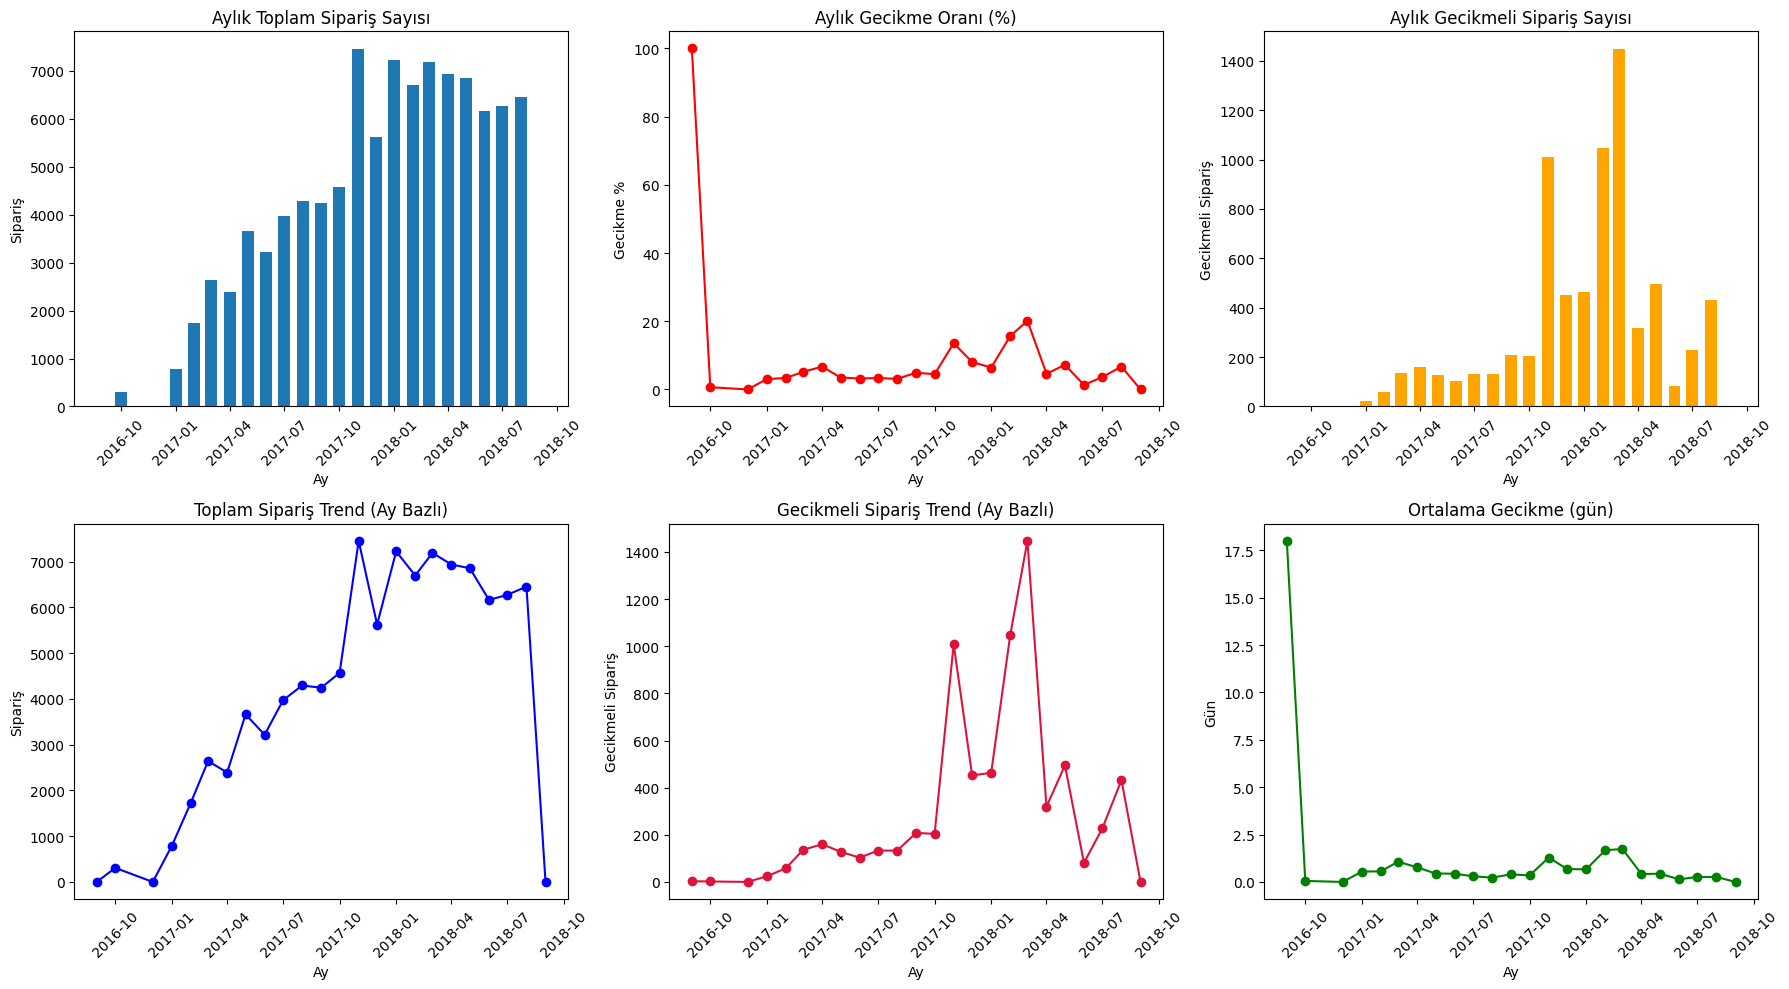

In [67]:
fact_order_shipments = fact_order_shipments.copy()
fact_order_shipments["order_purchase_timestamp"] = pd.to_datetime(
    fact_order_shipments["order_purchase_timestamp"], errors="coerce"
)
fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
fact_order_shipments["week"]  = fact_order_shipments["order_purchase_timestamp"].dt.isocalendar().week

# Aylık toplam ve gecikmeli siparişler
monthly = (
    fact_order_shipments
    .groupby(["year","month"])
    .agg(total_orders=("order_id_pref","nunique"),
         late_orders=("is_late","sum"),
         avg_delay=("delay_days","mean"))
    .reset_index()
)
monthly["late_pct"] = (monthly["late_orders"] / monthly["total_orders"]) * 100
monthly["date"] = pd.to_datetime(monthly[["year","month"]].assign(day=1))

# --- Çoklu Grafik Tablosu (2x3) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()  # kolay erişim

# 1) Aylık toplam siparişler
axes[0].bar(monthly["date"], monthly["total_orders"], width=20)
axes[0].set_title("Aylık Toplam Sipariş Sayısı")
axes[0].set_xlabel("Ay"); axes[0].set_ylabel("Sipariş")

# 2) Aylık gecikme oranı (%)
axes[1].plot(monthly["date"], monthly["late_pct"], marker="o", color="red")
axes[1].set_title("Aylık Gecikme Oranı (%)")
axes[1].set_xlabel("Ay"); axes[1].set_ylabel("Gecikme %")

# 3) Aylık gecikmeli sipariş adedi
axes[2].bar(monthly["date"], monthly["late_orders"], width=20, color="orange")
axes[2].set_title("Aylık Gecikmeli Sipariş Sayısı")
axes[2].set_xlabel("Ay"); axes[2].set_ylabel("Gecikmeli Sipariş")

# 4) Toplam sipariş trendi (çizgi)
axes[3].plot(monthly["date"], monthly["total_orders"], marker="o", color="blue")
axes[3].set_title("Toplam Sipariş Trend (Ay Bazlı)")
axes[3].set_xlabel("Ay"); axes[3].set_ylabel("Sipariş")

# 5) Gecikmeli sipariş trendi (adet + % etiket)
axes[4].plot(monthly["date"], monthly["late_orders"], marker="o", color="crimson")
axes[4].set_title("Gecikmeli Sipariş Trend (Ay Bazlı)")
axes[4].set_xlabel("Ay"); axes[4].set_ylabel("Gecikmeli Sipariş")

# 6) Ortalama gecikme (gün)
axes[5].plot(monthly["date"], monthly["avg_delay"], marker="o", color="green")
axes[5].set_title("Ortalama Gecikme (gün)")
axes[5].set_xlabel("Ay"); axes[5].set_ylabel("Gün")

# X‐etiketlerinin okunabilirliği
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Gecikme Analizi

In [68]:
# Toplam gecikmeli sipariş sayısını hesapla
total_late_orders = fact_order_shipments['is_late'].sum()
print("Toplam gecikmeli sipariş sayısı:", total_late_orders)

Toplam gecikmeli sipariş sayısı: 7265


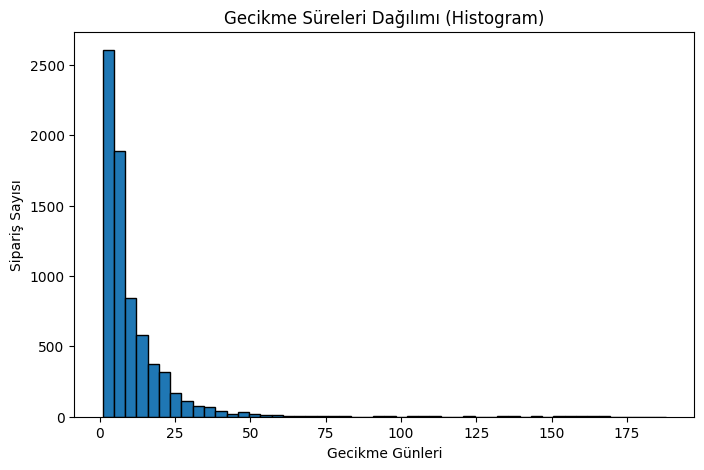

In [69]:
# Sadece gecikmeli siparişler
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

plt.figure(figsize=(8,5))
plt.hist(late_orders['delay_days'], bins=50, edgecolor='black')
plt.xlabel("Gecikme Günleri")
plt.ylabel("Sipariş Sayısı")
plt.title("Gecikme Süreleri Dağılımı (Histogram)")
plt.show()

### Gecikme günleri dağılımı – Boxplot

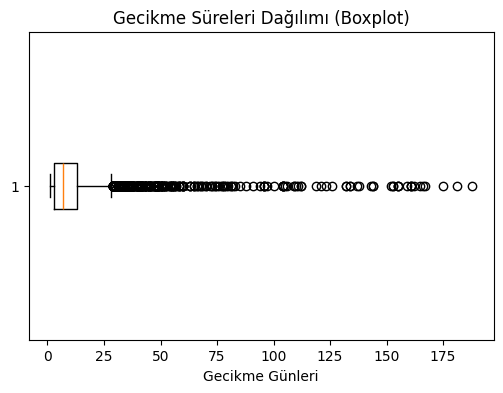

In [70]:
plt.figure(figsize=(6,4))
plt.boxplot(late_orders['delay_days'], vert=False)
plt.xlabel("Gecikme Günleri")
plt.title("Gecikme Süreleri Dağılımı (Boxplot)")
plt.show()

#### Özet istatistikler (ortalama, medyan, min, max)

In [71]:
mean_delay = late_orders['delay_days'].mean()
median_delay = late_orders['delay_days'].median()
min_delay = late_orders['delay_days'].min()
max_delay = late_orders['delay_days'].max()

print("Ortalama gecikme süresi:", mean_delay)
print("Medyan gecikme süresi:", median_delay)
print("Minimum gecikme süresi:", min_delay)
print("Maksimum gecikme süresi:", max_delay)

Ortalama gecikme süresi: 10.488781830695114
Medyan gecikme süresi: 7.0
Minimum gecikme süresi: 1.0
Maksimum gecikme süresi: 188.0


##  Müşteri, Satıcı ve Ürün Bazında Analiz

#### 1. Müşteri başına ortalama gecikme süresi

In [72]:
# Sadece gecikmesi olan siparişleri filtreleyelim
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

In [73]:

customer_delay_mean = late_orders.groupby("cusUni")["delay_days"].mean().reset_index()
customer_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
customer_delay_mean["avg_delay_days"] = customer_delay_mean["avg_delay_days"].astype(int)
customer_delay_mean.head()

,cusUni,avg_delay_days
0,CUSUNI0003,1
1,CUSUNI0019,8
2,CUSUNI0033,37
3,CUSUNI0060,15
4,CUSUNI0090,28


#### 2. Müşteri başına gecikmeli sipariş sayısı

In [74]:
customer_delay_count = late_orders.groupby("cusUni")["order_id_pref"].nunique().reset_index()
customer_delay_count.rename(columns={"order_id_pref": "late_order_count"}, inplace=True)
customer_delay_count.head()

,cusUni,late_order_count
0,CUSUNI0003,1
1,CUSUNI0019,1
2,CUSUNI0033,1
3,CUSUNI0060,1
4,CUSUNI0090,1


#### 3. En yüksek ortalama gecikmeye sahip müşteriler (ilk 10)

In [75]:
top_customers = customer_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_customers

,cusUni,avg_delay_days
4494,CUSUNI68968,188
1385,CUSUNI27483,181
4365,CUSUNI67222,175
3266,CUSUNI51868,167
946,CUSUNI21621,166
2058,CUSUNI3595,165
6047,CUSUNI90158,162
3531,CUSUNI55565,161
4465,CUSUNI68602,161
4328,CUSUNI66759,159


#### 4. Satıcı başına ortalama gecikme süresi

In [76]:
seller_delay_mean = late_orders.groupby("seller_id_pref")["delay_days"].mean().reset_index()
seller_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
seller_delay_mean.head()

,seller_id_pref,avg_delay_days
0,SEL001,3.000
1,SEL002,1.000
2,SEL005,7.000
3,SEL009,6.500
4,SEL010,17.583


#### 5. Tek satıcılı vs çok satıcılı siparişlerde gecikme karşılaştırması

In [77]:
# Her siparişin kaç farklı satıcı içeriyor:
order_seller_counts = fact_order_shipments.groupby("order_id_pref")["seller_id_pref"].nunique().reset_index()
order_seller_counts.rename(columns={"seller_id_pref": "seller_count"}, inplace=True)

# Gecikme bilgisi ile birlikte:
order_delay = fact_order_shipments.groupby("order_id_pref")["delay_days"].mean().reset_index()
order_seller_delay = order_delay.merge(order_seller_counts, on="order_id_pref")

# Tek satıcılı ve çok satıcılı siparişleri karşılaştırmasi:
comparison = order_seller_delay.groupby("seller_count")["delay_days"].mean().reset_index()
comparison

,seller_count,delay_days
0,1,0.712
1,2,0.044
2,3,0.000
3,4,0.000
4,5,0.000


#### 6. En yüksek ortalama gecikmeye sahip satıcılar (ilk 10)

In [78]:
top_sellers = seller_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_sellers

,seller_id_pref,avg_delay_days
948,SEL2930,167.000
559,SEL2076,159.000
789,SEL2602,134.000
644,SEL2267,132.000
688,SEL2352,132.000
912,SEL2857,100.000
196,SEL1321,97.000
401,SEL1745,91.000
534,SEL2031,80.000
866,SEL2762,76.000


#### 7. Ürün başına ortalama gecikme süresi

In [79]:
product_delay_mean = late_orders.groupby("product_id_pref")["delay_days"].mean().reset_index()
product_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
product_delay_mean.head()

,product_id_pref,avg_delay_days
0,PRO021,6.000
1,PRO027,7.000
2,PRO032,15.000
3,PRO034,13.000
4,PRO047,7.000


### Sipariş Gecikme Analizleri Dashboard

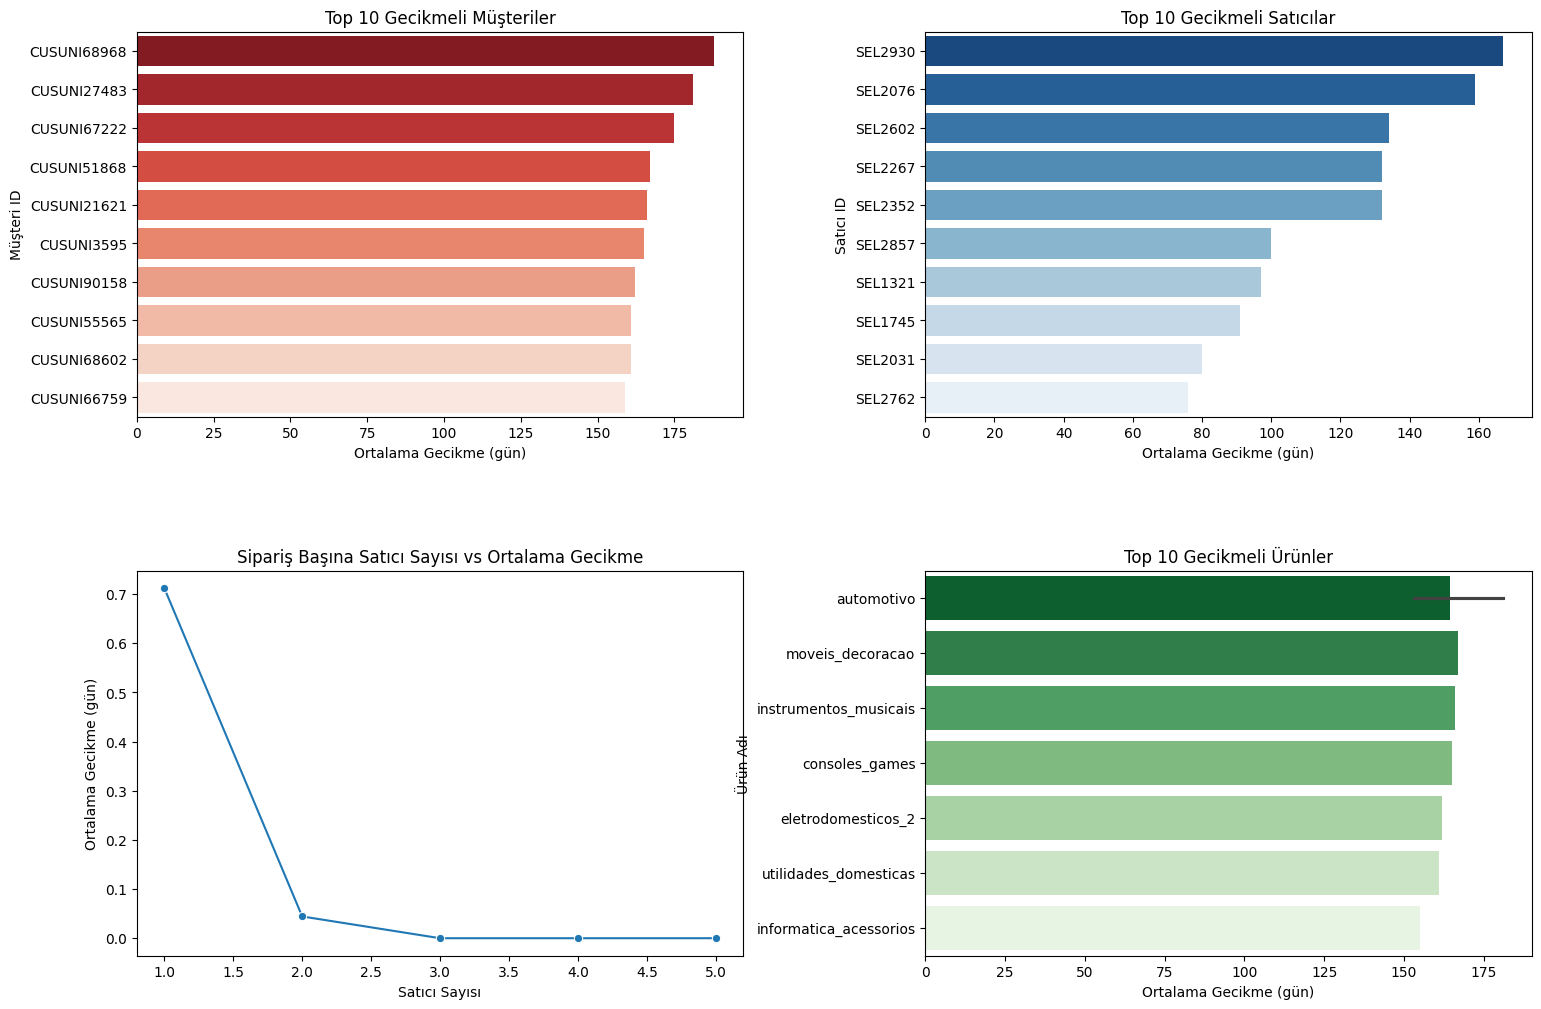

In [80]:
# Figure ve subplot yapısı (2 satır, 2 sütun)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1️ Top 10 gecikmeli müşteri
sns.barplot(
    data=top_customers,
    x="avg_delay_days",
    y="cusUni",
    palette="Reds_r",
    ax=axes[0,0]
)
axes[0,0].set_title("Top 10 Gecikmeli Müşteriler")
axes[0,0].set_xlabel("Ortalama Gecikme (gün)")
axes[0,0].set_ylabel("Müşteri ID")

# 2️ Top 10 gecikmeli satıcı
sns.barplot(
    data=top_sellers,
    x="avg_delay_days",
    y="seller_id_pref",
    palette="Blues_r",
    ax=axes[0,1]
)
axes[0,1].set_title("Top 10 Gecikmeli Satıcılar")
axes[0,1].set_xlabel("Ortalama Gecikme (gün)")
axes[0,1].set_ylabel("Satıcı ID")

# 3️ Sipariş başına satıcı sayısı vs ortalama gecikme
sns.lineplot(
    data=comparison,
    x="seller_count",
    y="delay_days",
    marker="o",
    ax=axes[1,0]
)
axes[1,0].set_title("Sipariş Başına Satıcı Sayısı vs Ortalama Gecikme")
axes[1,0].set_xlabel("Satıcı Sayısı")
axes[1,0].set_ylabel("Ortalama Gecikme (gün)")

# 4️ Top 10 gecikmeli ürün

# Top 10 gecikmeli ürün
top_products = product_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)

# Ürün isimlerini product tablosundan çekelim
top_products = top_products.merge(df_products[['product_id_pref', 'product_category_name']], 
                                  on='product_id_pref', how='left')

# Barplot
sns.barplot(
    data=top_products,
    x="avg_delay_days",
    y="product_category_name",  # product_name yerine doğru kolon adı
    palette="Greens_r",
    ax=axes[1,1]
)
axes[1,1].set_title("Top 10 Gecikmeli Ürünler")
axes[1,1].set_xlabel("Ortalama Gecikme (gün)")
axes[1,1].set_ylabel("Ürün Adı")

plt.show()





### Missing Values (Eksik Değerler)

In [81]:
fact_order_shipments.isnull().sum()

cusUni                              0
customer_order_id                   0
order_id_pref                       0
seller_id_pref                      0
product_id_pref                     0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
prep_time                        1209
shipping_time                    2455
estimated_time                     15
delay_days                          0
delay_class                         0
is_late                             0
distance_km                       554
payment_types                       3
payment_value_sum                   3
payment_installments_max            3
seller_count_per_order              0
year                                0
month                               0
week                                0
dtype: int64

### Missing Values Oranlari

                               n_miss  ratio
shipping_time                    2455  2.180
order_delivered_customer_date    2454  2.180
prep_time                        1209  1.070
order_delivered_carrier_date     1194  1.060
distance_km                       554  0.490
order_approved_at                  15  0.010
estimated_time                     15  0.010
payment_types                       3  0.000
payment_value_sum                   3  0.000
payment_installments_max            3  0.000


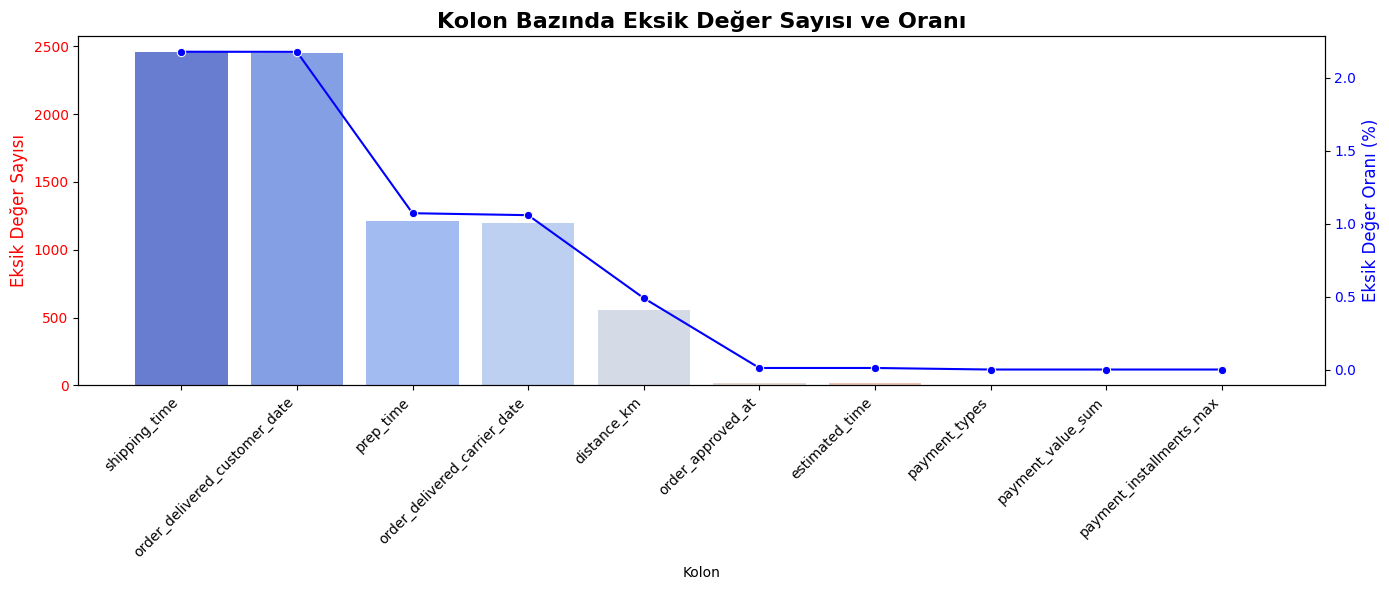

In [82]:
# Eksik kolon isimlerini al
na_cols = utils.table_missing_values(fact_order_shipments, na_name=True)

# Eksik değer sayısı ve oranını hesapla
n_miss = fact_order_shipments[na_cols].isnull().sum().sort_values(ascending=False)
ratio = (fact_order_shipments[na_cols].isnull().sum() / fact_order_shipments.shape[0] * 100).sort_values(ascending=False)

# DataFrame oluştur
na_df = pd.DataFrame({
    "Kolon": n_miss.index,
    "EksikDegerSayisi": n_miss.values,
    "Oran": ratio.values
})

# Figure oluştur
fig, ax1 = plt.subplots(figsize=(14,6))

# Bar plot: Eksik değer sayısı
sns.barplot(
    x="Kolon",
    y="EksikDegerSayisi",
    data=na_df,
    palette="coolwarm",
    ax=ax1
)
ax1.set_ylabel("Eksik Değer Sayısı", color="red", fontsize=12)
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# İkinci eksen: Oran
ax2 = ax1.twinx()
sns.lineplot(
    x="Kolon",
    y="Oran",
    data=na_df,
    color="blue",
    marker="o",
    ax=ax2
)
ax2.set_ylabel("Eksik Değer Oranı (%)", color="blue", fontsize=12)
ax2.tick_params(axis='y', labelcolor="blue")

plt.title("Kolon Bazında Eksik Değer Sayısı ve Oranı", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



In [83]:
utils.missing_VS_target(fact_order_shipments, "is_late", na_cols)

                           TARGET_MEAN   Count
order_approved_at_NA_FLAG                     
0                                0.065  112635
1                                0.000      15


                                      TARGET_MEAN   Count
order_delivered_carrier_date_NA_FLAG                     
0                                           0.065  111456
1                                           0.001    1194


                                       TARGET_MEAN   Count
order_delivered_customer_date_NA_FLAG                     
0                                            0.066  110196
1                                            0.000    2454


                   TARGET_MEAN   Count
prep_time_NA_FLAG                     
0                        0.065  111441
1                        0.001    1209


                       TARGET_MEAN   Count
shipping_time_NA_FLAG                     
0                            0.066  110195
1                            0.000    2455


      

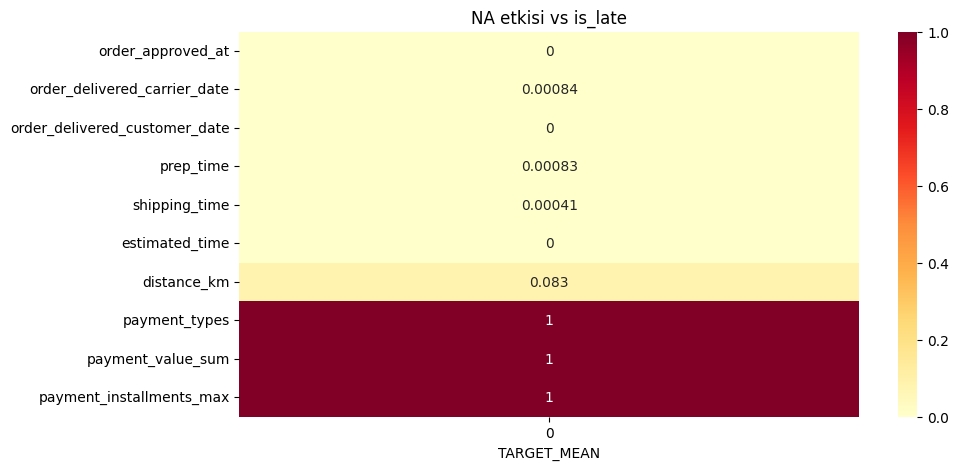

In [84]:
utils.missing_target_heatmap(fact_order_shipments, "is_late", na_cols)

In [85]:
fact_order_clean = utils.handle_missing_values(fact_order_shipments)
print(f"Orijinal satır sayısı: {fact_order_shipments.shape[0]}")
print(f"Temizlenmiş satır sayısı: {fact_order_clean.shape[0]}")

Orijinal satır sayısı: 112650
Temizlenmiş satır sayısı: 112647


In [86]:
fact_order_clean.shape

(112647, 29)

In [87]:
fact_order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112647 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   cusUni                         112647 non-null  object        
 1   customer_order_id              112647 non-null  object        
 2   order_id_pref                  112647 non-null  object        
 3   seller_id_pref                 112647 non-null  object        
 4   product_id_pref                112647 non-null  object        
 5   order_purchase_timestamp       112647 non-null  datetime64[ns]
 6   order_approved_at              112647 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111453 non-null  datetime64[ns]
 8   order_delivered_customer_date  110193 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112647 non-null  datetime64[ns]
 10  prep_time                      112647 non-null  float64       
 11  shipp

In [88]:
# Mevcut kolon UInt32Dtype ise önce .to_numpy() ile numpy array’e çevir
fact_order_clean['week'] = fact_order_clean['week'].to_numpy(dtype='int32')

In [89]:
fact_order_clean.dtypes['week']

dtype('int32')

In [90]:
fact_order_clean.shape

(112647, 29)

### Negatif değerler 

In [91]:
time_cols = ["prep_time", "shipping_time", "estimated_time"]

for col in time_cols:
    fact_order_clean[col] = fact_order_clean[col].clip(lower=0)

# Temizlik sonrası kontrol
for col in time_cols:
    print(f"=== {col} ===")
    print("Min value:", fact_order_clean[col].min())
    print("Negative values count:", (fact_order_clean[col] < 0).sum())
    print("Missing values:", fact_order_clean[col].isnull().sum())

=== prep_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0
=== shipping_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0
=== estimated_time ===
Min value: 0.0
Negative values count: 0
Missing values: 0


#############################################
### 1. Outliers (Aykırı Değerler)
#############################################

In [92]:
fact_order_clean.head()

,cusUni,customer_order_id,order_id_pref,seller_id_pref,product_id_pref,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,prep_time,shipping_time,estimated_time,delay_days,delay_class,is_late,distance_km,payment_types,payment_value_sum,payment_installments_max,seller_count_per_order,year,month,week,shipping_time_NA_FLAG,prep_time_NA_FLAG,distance_km_NA_FLAG,order_approved_at_NA_FLAG,estimated_time_NA_FLAG
0,CUSUNI64073,CUS65558,ORD85268,SEL514,PRO25866,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,6.000,1.000,15.000,0.000,0,0,301.505,credit_card,72.190,2.000,1,2017,9,37,0,0,0,0,0
1,CUSUNI33838,CUS34266,ORD71854,SEL472,PRO27231,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,8.000,8.000,18.000,0.000,0,0,585.565,credit_card,259.830,3.000,1,2017,4,17,0,0,0,0,0
2,CUSUNI34511,CUS34956,ORD6299,SEL1825,PRO22625,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1.000,6.000,21.000,0.000,0,0,312.344,credit_card,216.870,5.000,1,2018,1,2,0,0,0,0,0
3,CUSUNI50803,CUS51764,ORD22551,SEL2024,PRO15404,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2.000,4.000,11.000,0.000,0,0,293.169,credit_card,25.780,2.000,1,2018,8,32,0,0,0,0,0
4,CUSUNI7582,CUS7603,ORD5248,SEL1598,PRO8863,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,11.000,13.000,40.000,0.000,0,0,646.164,credit_card,218.040,3.000,1,2017,2,5,0,0,0,0,0


### LOF Modeli ile çok değişkenli aykırı değer tespiti

In [93]:
# Outlier kontrolü yapmak istediğimiz kolonlar
num_cols_for_lof = [
    'prep_time', 'shipping_time', 'estimated_time', 
    'distance_km', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order'
]

### LOF ile aykırı değer tespiti

In [94]:

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # %5 uç değerler
lof_labels = lof.fit_predict(fact_order_clean[num_cols_for_lof])
lof_scores = lof.negative_outlier_factor_
print("\nİlk 5 LOF skoru:", lof_scores[0:5])


İlk 5 LOF skoru: [-1.15045438 -1.0087608  -0.98111699 -1.13674666 -1.21025696]


### Eşik değer görselleştirme

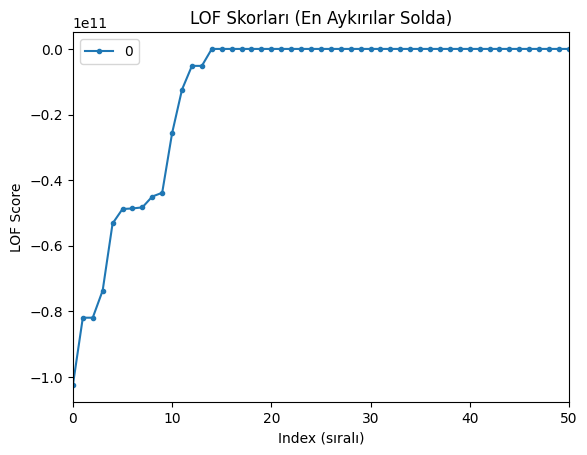

In [95]:
scores = pd.DataFrame(np.sort(lof_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.xlabel("Index (sıralı)")
plt.ylabel("LOF Score")
plt.title("LOF Skorları (En Aykırılar Solda)")
plt.show()

In [96]:
outliers_index = fact_order_clean[num_cols_for_lof].index[lof_labels == -1]
print("Aykırı satır sayısı:", len(outliers_index))

Aykırı satır sayısı: 5633


### Aykırı değerleri alt-üst limit yöntemiyle eşitle 

In [97]:
for col in num_cols_for_lof:
    utils.replace_with_thresholds(fact_order_clean, col)
    print("Aykırı değerler alt-üst limitlere eşitlendi.")

Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.


In [98]:
utils.check_outliers_for_columns(fact_order_clean, num_cols_for_lof)

{'prep_time': False,
 'shipping_time': False,
 'estimated_time': False,
 'distance_km': False,
 'payment_value_sum': False,
 'payment_installments_max': False,
 'seller_count_per_order': False}


=== prep_time ===
Original describe:
count   111441.000
mean         2.348
std          3.600
min       -172.000
25%          0.000
50%          1.000
75%          3.000
max        125.000
Name: prep_time, dtype: float64
Cleaned describe:
count   112647.000
mean         2.045
std          2.180
min          0.000
25%          0.000
50%          1.000
75%          3.000
max          7.500
Name: prep_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


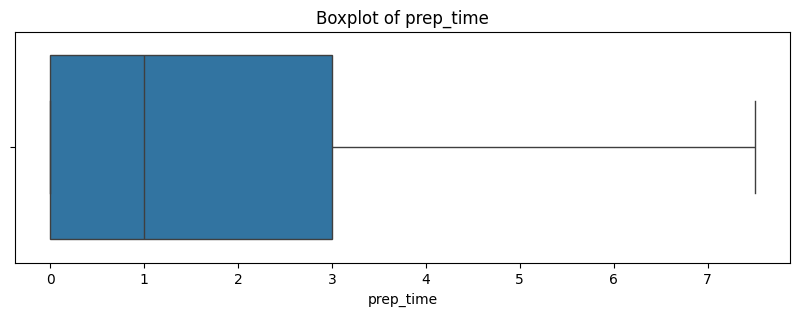

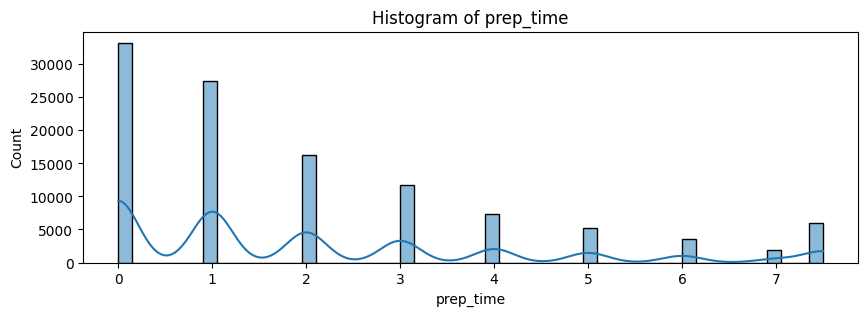


=== shipping_time ===
Original describe:
count   110195.000
mean         8.734
std          8.612
min        -17.000
25%          4.000
50%          7.000
75%         11.000
max        205.000
Name: shipping_time, dtype: float64
Cleaned describe:
count   112647.000
mean         8.042
std          5.849
min          0.000
25%          4.000
50%          7.000
75%         11.000
max         21.500
Name: shipping_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


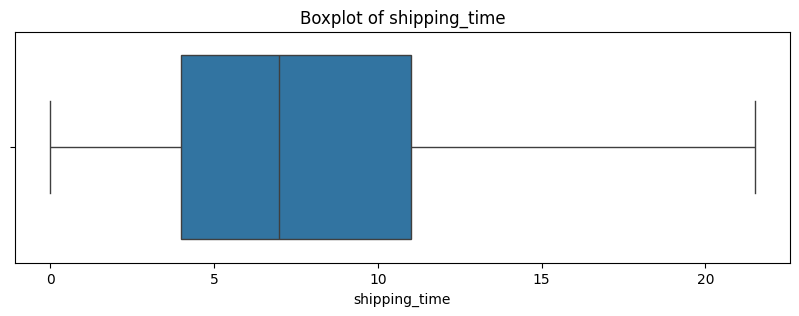

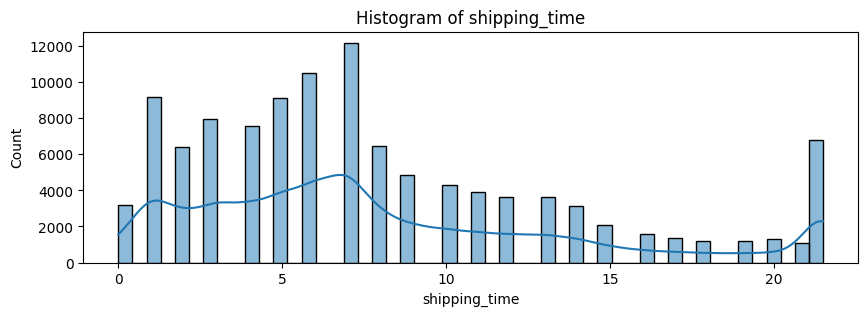


=== estimated_time ===
Original describe:
count   112635.000
mean        22.942
std          8.901
min         -7.000
25%         18.000
50%         22.000
75%         28.000
max        153.000
Name: estimated_time, dtype: float64
Cleaned describe:
count   112647.000
mean        22.756
std          8.222
min          3.000
25%         18.000
50%         22.000
75%         28.000
max         43.000
Name: estimated_time, dtype: float64
Negative values after cleaning: 0
Missing values: 0


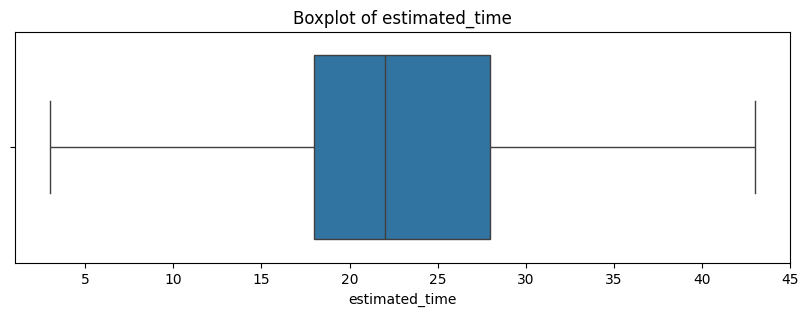

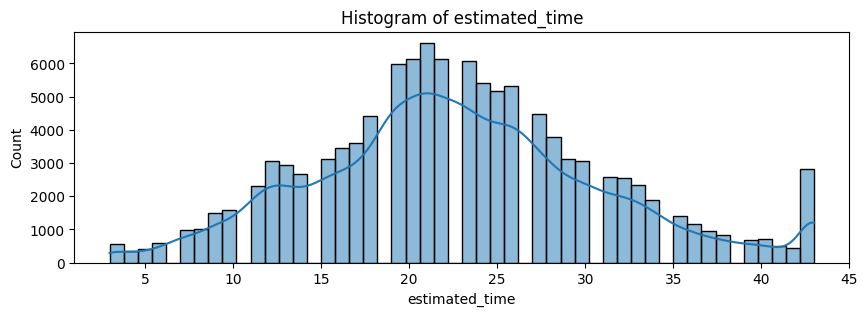


=== distance_km ===
Original describe:
count   112096.000
mean       596.960
std        589.980
min          0.000
25%        184.066
50%        431.636
75%        792.277
max       8677.924
Name: distance_km, dtype: float64
Cleaned describe:
count   112647.000
mean       557.096
std        482.084
min          0.000
25%        187.573
50%        431.636
75%        789.029
max       1691.212
Name: distance_km, dtype: float64
Negative values after cleaning: 0
Missing values: 0


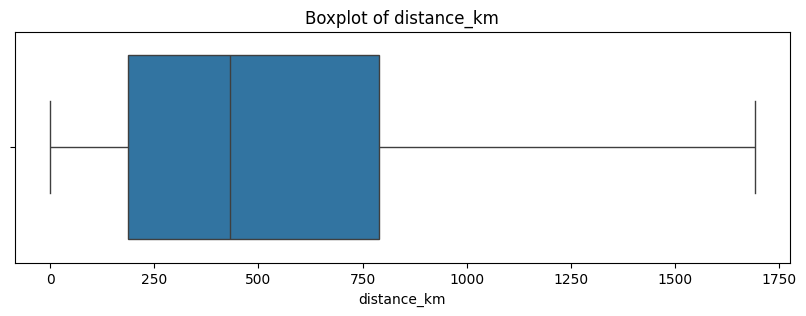

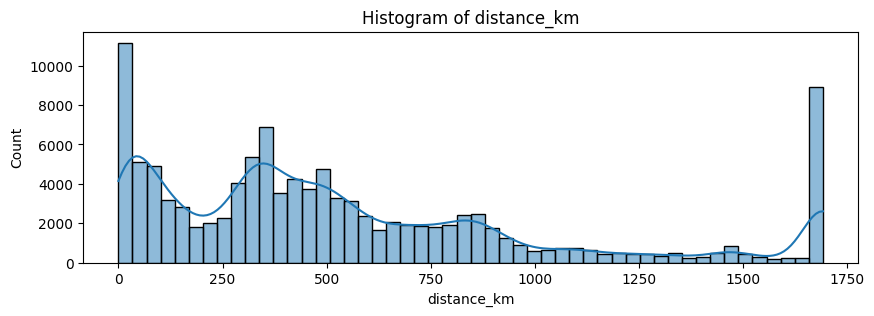


=== payment_value_sum ===
Original describe:
count   112647.000
mean       180.281
std        272.849
min          9.590
25%         65.670
50%        114.440
75%        195.390
max      13664.080
Name: payment_value_sum, dtype: float64
Cleaned describe:
count   112647.000
mean       147.465
std        106.603
min          9.590
25%         65.670
50%        114.440
75%        195.390
max        389.970
Name: payment_value_sum, dtype: float64
Negative values after cleaning: 0
Missing values: 0


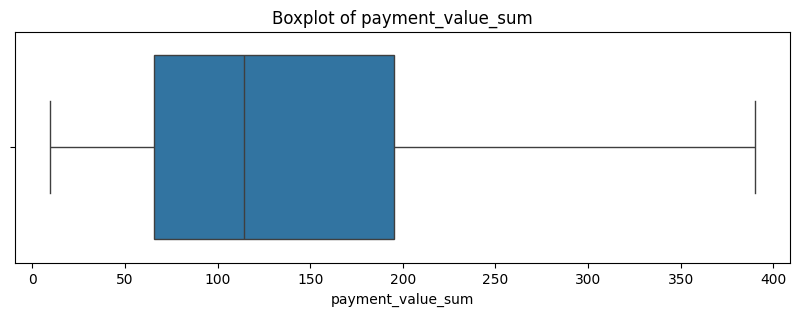

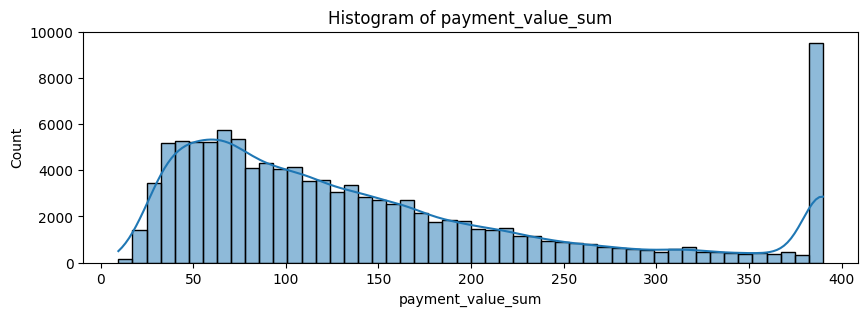


=== payment_installments_max ===
Original describe:
count   112647.000
mean         3.018
std          2.803
min          0.000
25%          1.000
50%          2.000
75%          4.000
max         24.000
Name: payment_installments_max, dtype: float64
Cleaned describe:
count   112647.000
mean         2.900
std          2.489
min          0.000
25%          1.000
50%          2.000
75%          4.000
max          8.500
Name: payment_installments_max, dtype: float64
Negative values after cleaning: 0
Missing values: 0


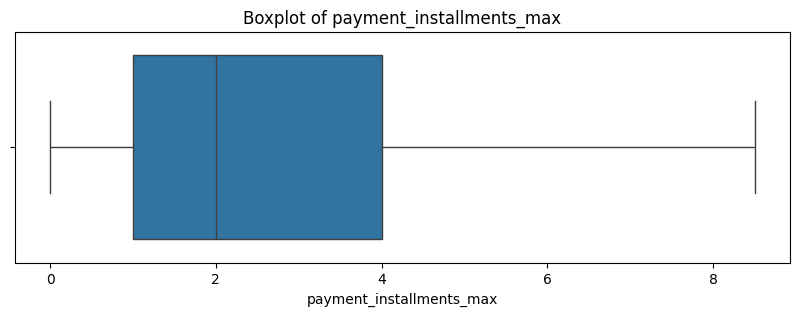

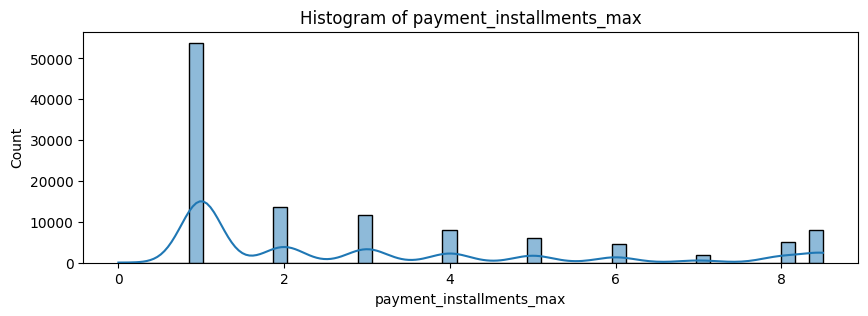


=== seller_count_per_order ===
Original describe:
count   112650.000
mean         1.030
std          0.186
min          1.000
25%          1.000
50%          1.000
75%          1.000
max          5.000
Name: seller_count_per_order, dtype: float64
Cleaned describe:
count   112647.000
mean         1.000
std          0.000
min          1.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
Name: seller_count_per_order, dtype: float64
Negative values after cleaning: 0
Missing values: 0


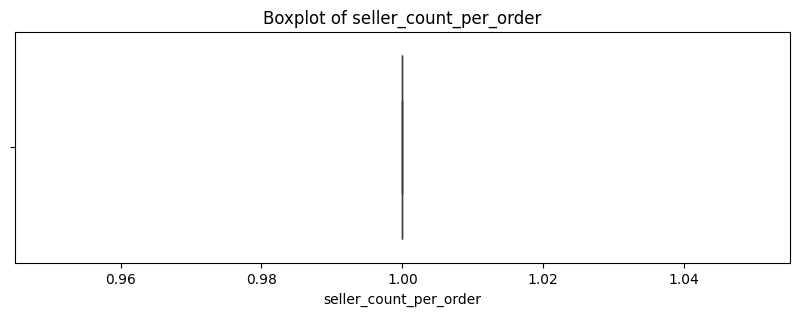

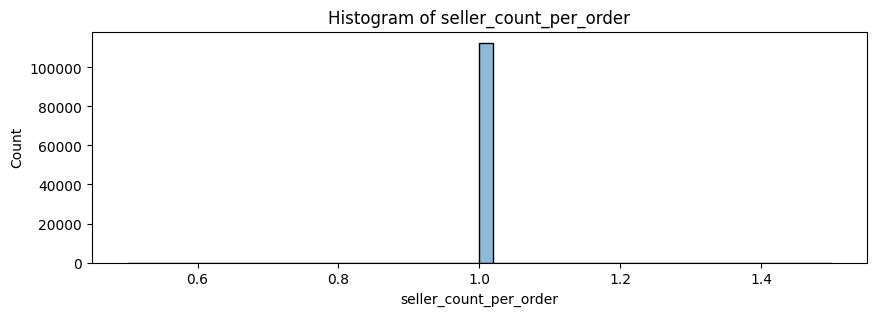

In [99]:
utils.check_outlier_cleaning(fact_order_shipments, fact_order_clean, num_cols_for_lof)

## Veri Temizleme ve Aykırı Değer İşlemleri

Bu adımda, modelleme öncesi veri setinin kalitesini artırmak için eksik değerlerin ve aykırı değerlerin temizlenmesi, sayısal değişkenlerin mantıksal sınırlar içinde tutulması gibi işlemler yapıldı. İşlemler aşağıdaki şekilde gerçekleştirildi:

#### 1. Eksik Değerlerin İşlenmesi

Neden:
Eksik değerler modelin doğruluğunu düşürebilir veya algoritmaların çalışmasını engelleyebilir. Bazı algoritmalar (ör. LocalOutlierFactor) eksik değerleri işleyemez.

Nasıl:

Her kolon için eksik değerler sayıldı ve yüzdesi hesaplandı.

Eksik değer oranı çok düşük olan satırlar silindi veya eksik değerler uygun bir şekilde işaretlendi (NA_FLAG).

Örnek: prep_time, shipping_time, distance_km gibi kolonlarda eksik değerler temizlendi.

Sonuç:

Tüm eksik değerler işlendikten sonra veri setinde eksik değer kalmadı.

Temizleme sonrası satır sayısı orijinal veri setine çok yakın kaldı, veri kaybı minimum düzeyde oldu.

#### 2. Mantıksal Alt ve Üst Limitlerin Uygulanması

Neden:
Bazı değişkenlerde negatif değerler veya mantıksal olarak mümkün olmayan değerler bulunabiliyordu (ör. prep_time negatif olamaz). Bu tür değerler modelin yanlış öğrenmesine neden olabilir.

Nasıl:

prep_time, shipping_time, estimated_time gibi sayısal değişkenler için alt limit 0 olarak belirlendi.

Negatif değerler bu alt limite eşitlendi.

Sonuç:

Temizlik sonrası bu kolonlarda negatif değer kalmadı.

Mantıksal olarak geçerli veri aralıkları sağlanmış oldu.

#### 3. Aykırı Değerlerin Tespiti ve İşlenmesi

Neden:
Aykırı değerler modelin performansını bozabilir, istatistiksel özetleri yanıltabilir ve bazı algoritmaların sonuçlarını dengesizleştirebilir.

Nasıl:

Sayısal değişkenler için Local Outlier Factor (LOF) yöntemi ile uç değerler tespit edildi.

Tespit edilen uç değerler, IQR yöntemi ile belirlenen alt ve üst eşiklere (Q1 - 1.5*IQR, Q3 + 1.5*IQR) göre sınırlandırıldı.

Böylece aşırı uç değerler veri setine zarar vermeden normalize edildi.

Sonuç:

Örnek: prep_time değişkenindeki maksimum değer 125’ten 7.5’e düşürüldü.


shipping_time, estimated_time, distance_km, payment_value_sum gibi değişkenlerde mantıksal sınırlar sağlandı.

Temizleme sonrası veri seti modelleme için daha güvenli ve dengeli hale geldi.


Bu işlemler tamamlandıktan sonra veri seti:

Eksik değerlerden arındırıldı,

Mantıksal olarak geçerli aralıklara getirildi,

Aykırı değerlerin etkisi minimize edildi.

Artık veri seti, özellik mühendisliği, encoding ve modelleme adımlarına hazırdır.

In [100]:
fact_order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112647 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   cusUni                         112647 non-null  object        
 1   customer_order_id              112647 non-null  object        
 2   order_id_pref                  112647 non-null  object        
 3   seller_id_pref                 112647 non-null  object        
 4   product_id_pref                112647 non-null  object        
 5   order_purchase_timestamp       112647 non-null  datetime64[ns]
 6   order_approved_at              112647 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111453 non-null  datetime64[ns]
 8   order_delivered_customer_date  110193 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112647 non-null  datetime64[ns]
 10  prep_time                      112647 non-null  float64       
 11  shipp

In [101]:
output_path = "cleaned_data_with_prefix_id/fact_order_clean.csv"
fact_order_clean.to_csv(output_path, index=False)

## Encoding işlemleri

Makine öğrenmesi modellerinde ön işleme adımları (özellikle ölçekleme – scaling ve kategorik değişkenlerin kodlanması – encoding) modelin başarısı için kritik öneme sahiptir. Çünkü ham verilerde bulunan değişkenler farklı tiplerde olabilir: sayısal değerler (ör. süre, mesafe, fiyat), kategorik değerler (ör. ödeme tipi), ikili değişkenler (ör. evet/hayır), tarih–zaman bilgileri ya da yalnızca tanımlayıcı ID’ler. Bu farklı türdeki değişkenler aynı modelde doğrudan kullanıldığında, ölçek farkları ya da temsil biçiminden kaynaklanan sorunlar modelin öğrenmesini zorlaştırır ve yanlı tahminlere yol açar.

Ölçekleme (scaling), özellikle _sayısal değişkenlerde_ önemlidir çünkü farklı büyüklükteki değişkenler (örneğin binler seviyesindeki ödeme tutarı ile tek haneli hazırlık süresi) aynı modelde kullanıldığında, bazı algoritmalar büyük değere sahip değişkenleri daha baskın kabul edebilir. Böylece model yanlış yönlenir. Bu nedenle sayısal değişkenler genellikle aynı ölçeğe getirilir. Bunun için _StandardScaler_, _MinMaxScaler_, _RobustScaler_ gibi yöntemler kullanılabilir. Çarpık dağılımlarda _logaritmik dönüşümler_ de sıkça tercih edilir.

Encoding (kategorik değişkenlerin kodlanması) ise, metinsel veya _kategorik verilerin_ makine öğrenmesi algoritmalarına sayısal olarak tanıtılması için gereklidir. Çünkü çoğu algoritma doğrudan string veya kategori ifadeleriyle çalışamaz. Burada kullanılan yöntem, kategorinin çeşitliliğine göre değişir: _az sayıda kategori varsa One-Hot Encoding_, _çok fazla kategori varsa Target Encoding, Frequency Encoding veya Hashing_ gibi alternatifler kullanılabilir.

Bu nedenle bir veri seti üzerinde çalışırken öncelikle değişkenlerin tiplerine bakmak, ardından her tip için uygun dönüşümü seçmek gerekir. Aynı tipte görünseler bile, değişkenlerin içeriği veya modelle olan ilişkisi farklı işlemleri gerektirebilir. Örneğin iki değişken de numerik olabilir ama biri log dönüşümüne ihtiyaç duyarken diğeri doğrudan ölçeklenebilir; ya da biri hedef değişkenle doğrudan ilişkili olduğu için kullanılmamalıdır.

#### Data Tiplerine Göre Genel Kurallar

* ID / Key değişkenleri : (ör. müşteri ID, sipariş ID) → Modelde kullanılmaz; sadece eşleştirme/join için tutulur.

* Datetime değişkenleri : Ham haliyle kullanılmaz; içinden yıl, ay, hafta, gün, hafta içi/hafta sonu, saat gibi türev özellikler çıkarılır.

* Sayısal değişkenler (float/int) : Eksik değerler doldurulur; gerekirse log dönüşümü yapılır; ardından StandardScaler veya RobustScaler ile ölçeklenir.

* Binary değişkenler (0/1, evet/hayır) *: Olduğu gibi bırakılır, encoding veya scaling gerekmez.

* Kategorik değişkenler : Kategori sayısına göre farklı encoding yöntemleri seçilir. Az kategori → One-Hot; çok kategori → Target/Frequency encoding.

* Hedef değişken (target) : Encoding veya scaling yapılmaz, yalnızca modelin çıktısıdır.

Elimizdeki veri setinde toplam 24 kolon vardır. Öncelikle kolonları tiplerine göre sınıflandırabiliriz:

* ID/Key: cusUni, customer_order_id, order_id_pref, seller_id_pref, product_id_pref

* Datetime: order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date

* Sayısal (float/int): prep_time, shipping_time, estimated_time, delay_days, distance_km, payment_value_sum, payment_installments_max, seller_count_per_order

* Binary / Sınıf etiketleri: is_late, delay_class

* Kategorik (object): payment_types

* Datetime türevleri (int): year, month, week

Target kolonlarının tespiti ve dataframeden ayırma 

Neden?
Modelin tahmin edeceği değişken(ler) (is_late, delay_class, delay_days) özellik matriksine (X) dahil edilirse bilgi sızıntısı (data leakage) oluşur. Bu, eğitimde yapay olarak yüksek skor verir ama gerçek hayatta performans düşer. Bu nedenle hedef(ler)i ayrı y değişkeni olarak alıp X’ten tamamen çıkarmalıyız.

Aşağıdaki kod, fact_order_shipments’tan:

Hangi hedefi kullanacağını seçer (varsayılan: is_late),

y vektörünü hazırlar,

Tüm target sütunlarını X’ten düşer,

Kontrol amaçlı şekil ve sınıf dağılımını yazdırır.

Not: Henüz encoding/scaling yok — sadece target ayrımı yapıyoruz. Sonraki adımlarda pipeline’a ekleyeceğiz.

 — Sürekli sayısallar için log1p + RobustScaler

Bu kolonlar (prep_time, shipping_time, estimated_time, distance_km, payment_value_sum) sağa çarpık ve uç değerlere duyarlı.

log1p (yani log(1+x)) dağılımı dengeler, 0 değerlerinde güvenle çalışır.

Negatif değerler istisnai olarak gelebilir (hesap/parse kaynaklı) → 0’a kırpıp sonra log1p uyguluyoruz.

Ölçekleme olarak RobustScaler (medyan/IQR) uç değerlere karşı daha dayanıklıdır.

Tüm dönüşümler train/test sızıntısı olmaması için Pipeline/ColumnTransformer içinde yapılır.

Not: Bu adımda sadece sürekli sayısalların dönüşümünü kuruyoruz. payment_installments_max StandardScaler’ı bir sonraki adımda ekleyeceğiz.

 — payment_installments_max için StandardScaler ve year / month / week / seller_count_per_order için One-Hot

payment_installments_max sayısal ama küçük aralıkta → StandardScaler yeterli ve yorumlanabilir.

year, month, week, seller_count_per_order sayısal görünse de kategori benzeri (ay, hafta, satıcı adedi gibi ayrık sınıflar). Bu yüzden one-hot daha uygundur.

Tüm dönüşümleri tek bir ColumnTransformer içinde toplayıp data leakage (sızıntı) riskini ortadan kaldırıyoruz (fit sadece train’de yapılır).

Not: Kurduğumuz log1p + RobustScaler bloğunu koruyoruz ve bu adımda yeni blokları aynı ColumnTransformer içine ekliyoruz. Ödeme tipleri (multi-hot + dominant) Adım 4’te gelecek.

Ödeme tipleri: multi-hot + (opsiyonel) dominant_payment_type

payment_types bir satırda birden fazla yöntemi içerebilir ("credit_card/boleto" gibi). Klasik one-hot bunu tek kategori sanır → bilgi kaybı.

Multi-hot (multi-label) ile her yöntemi ayrı 0/1 sütuna çeviririz: hem credit_card=1 hem boleto=1 olabilir.

dominant_payment_type (opsiyonel): domain bilgisini tek bir özet kolona sıkıştırır. Örn. boleto varsa yavaş/onay gecikmesi riski yüksek olduğu için “en riskli” olarak onu seçeriz. Modelin yorumlanabilirliğini artırır; multi-hot ile birlikte kullanılabilir.


PaymentTypeEncoder adlı özel bir sklearn transformer oluşturur:

payment_types kolonunu / ile ayırır, temizler, multi-hot sütunları üretir,

dominant_payment_type kolonu ekler (risk sırasına göre).

Bunu pipeline’ın ilk adımına koyarız (fit sadece train’de → leakage yok).


1) Aday listeleri

NUM_LOG_ROBUST_CANDIDATES: Süre/mesafe/para gibi ≥0, sağa çarpık ve outlier’lı sayısallar → bunlara log1p + RobustScaler uygulayacağız.

NUM_STD_CANDIDATES: Ölçeği farklı ama dağılımı daha dengeli sayısal kolonlar → StandardScaler yeterli.

OHE_CANDIDATES_KAT_SAYISAL: Aslında sayısal görünüp kategorik gibi davranan (yıl/ay/hafta, satıcı sayısı gibi) kolonlar → One-Hot.

2) Yardımcı dönüştürücüler

clip_nonneg: Negatif değerleri 0’a kırpar (log’dan önce güvenlik).

log1p: log(1+x); sıfırları da güvenle dönüştürür, sağa çarpıklığı azaltır.

3) Sayısal pipeline’lar

num_log_robust (log+robust hattı):

SimpleImputer(median): Eksikleri medyanla doldur (outlier’lara dayanıklı).

clip0: Negatifleri 0’a çek.

log1p: Çarpıklığı düşür.

RobustScaler(): Median/IQR ile outlier dayanıklı ölçekleme.

num_std (standart hattı):

SimpleImputer(median)

StandardScaler(): Ortalama 0, std 1 ölçek.

4) Kategorik pipeline

cat_ohe:

SimpleImputer(most_frequent): Eksik kategoriyi mod ile doldur.

OneHotEncoder(handle_unknown="ignore", sparse_output=False): Eğitimde görülmeyen kategori gelirse hata vermez; dense matris döndürür.

— ID’ler için frequency + target encoding (leakage’siz)

cusUni, seller_id_pref, product_id_pref gibi yüksek kardinaliteli ID’ler ham haliyle modele verilmez.
Bunlardan genelleştirilebilir ve yorumlanabilir iki tür özellik üretiriz:

Frequency encoding → o müşterinin/satıcının/ürünün kaç siparişte yer aldığı

Target encoding (safely) → o ID’nin gecikme oranı (ör. satıcının geçmiş geç kalma oranı)

Kritik nokta: Bu istatistikler yalnızca train verisinde hesaplanır; test’e map edilir (aksi halde data leakage olur).
Az gözlemli ID’lerde aşırı oynamayı azaltmak için smoothing uygularız.

Kod – Train/Test güvenli ID encoding

Aşağıdaki yardımcılar:

fit_id_stats(...) → train üstünde freq ve smoothed late_rate hesaplar

apply_id_stats(...) → herhangi bir X’e *_freq, *_late_rate kolonlarını ekler; ham ID kolonunu drop eder

add_all_id_encodings(...) → üç ID için tek seferde uygular

Not: Target olarak is_late (binary) kullanıyoruz. Başka target seçtiysen parametreyi değiştir.

Ham ID kolonları (cusUni, seller_id_pref, product_id_pref) yok → onlar encoding sonrası drop edildi

Yerlerine şu kolonlar geldi:

`cust_freq, cust_late_rate, seller_freq, seller_late_rate ,product_freq, product_late_rate`

Ayrıca zaten daha önce hesaplanan türev süreler (prep_time, shipping_time, estimated_time) ve mesafe (distance_km) var.

Tarih kolonları ise hâlen duruyor:

order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date
bu kolonları işeyip df'den ççıkartacağız. 

Kategorik olarak sadece payment_types kaldı →  PaymentTypeEncoder ile çoklu sütunlara açılacak.

Ekstra “takvim” değişkenleri (year, month, week) ve seller_count_per_order da var.

Kategorik encoding (payment_types + diğer kategorikler)

Bu adımda: payment_types → PaymentTypeEncoder ile Multi-hot sütunlar (credit_card, boleto, debit_card, voucher …)

Opsiyonel dominant_payment_type

year, month, week, seller_count_per_order, dominant_payment_type → One-Hot Encoder

Multi-hot ödeme tipleri zaten binary sayısal olacak → ColumnTransformer’da passthrough ile bırakacağız.

###  Train / Test Split

In [102]:
# Target belirle
TARGET = "is_late"   # delay_days veya delay_class da seçilebilirdi

y = fact_order_clean[TARGET].astype(int)
X = fact_order_clean.drop(columns=[TARGET])

# Train / Test split (stratified: class dengesizliği korunur)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature engineering & missing value handling
X_train_feat = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_train))
X_test_feat  = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_test))

# --- Payment Type Encoding ---
pt_encoder = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat = pt_encoder.fit_transform(X_train_feat)
X_test_feat = pt_encoder.transform(X_test_feat)


# Kaçak (leakage) kolonları temizle
X_train_feat = utils.drop_leakage_columns(X_train_feat)
X_test_feat  = utils.drop_leakage_columns(X_test_feat)


### Datetime dönüşümü

In [103]:
datetime_cols = ["order_purchase_timestamp", "order_approved_at", "order_estimated_delivery_date"]
for c in datetime_cols:
    if c in X_train.columns:
        X_train[c] = pd.to_datetime(X_train[c], errors="coerce")
        X_test[c]  = pd.to_datetime(X_test[c], errors="coerce")

### Pipeline Uygulama

In [104]:
# ID encoding
id_plan = [("cusUni","cust"), ("seller_id_pref","seller"), ("product_id_pref","product")]
X_train_ids, X_test_ids, id_models = utils.add_all_id_encodings(X_train_feat, X_test_feat, y_train, id_plan=id_plan)

# Preprocessor pipeline
preprocessor = utils.build_full_preprocessor_leakfree(X_train_ids)
Xtr_prep = preprocessor.fit_transform(X_train_ids, y_train)
Xte_prep = preprocessor.transform(X_test_ids)

print("Xtr_prep shape:", Xtr_prep.shape)
print("Xte_prep shape:", Xte_prep.shape)

Xtr_prep shape: (90117, 86)
Xte_prep shape: (22530, 86)


In [105]:
X_train_ids.columns

Index(['distance_km', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order', 'year', 'month', 'week', 'distance_km_NA_FLAG', 'order_approved_at_NA_FLAG', 'dayofweek', 'hour', 'boleto', 'credit_card', 'debit_card', 'voucher', 'dominant_payment_type', 'cust_freq', 'cust_late_rate', 'seller_freq', 'seller_late_rate', 'product_freq', 'product_late_rate'], dtype='object')

### LR  ile veri degerlendirme

In [106]:
clf = LogisticRegression(max_iter=5000, class_weight="balanced")

# Xtr_prep tamamen numeric, pipeline’a gerek yok
clf.fit(Xtr_prep, y_train)  

p = clf.predict_proba(Xte_prep)[:, 1]
yhat = (p >= 0.5).astype(int)

print("ROC-AUC :", roc_auc_score(y_test, p))
print("PR-AUC  :", average_precision_score(y_test, p))
print("F1      :", f1_score(y_test, yhat))
print("CM:\n", confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat, digits=3))

ROC-AUC : 0.7495579844194082
PR-AUC  : 0.18823233288260907
F1      : 0.24272340425531916
CM:
 [[17368  3710]
 [  739   713]]
              precision    recall  f1-score   support

           0      0.959     0.824     0.886     21078
           1      0.161     0.491     0.243      1452

    accuracy                          0.803     22530
   macro avg      0.560     0.658     0.565     22530
weighted avg      0.908     0.803     0.845     22530



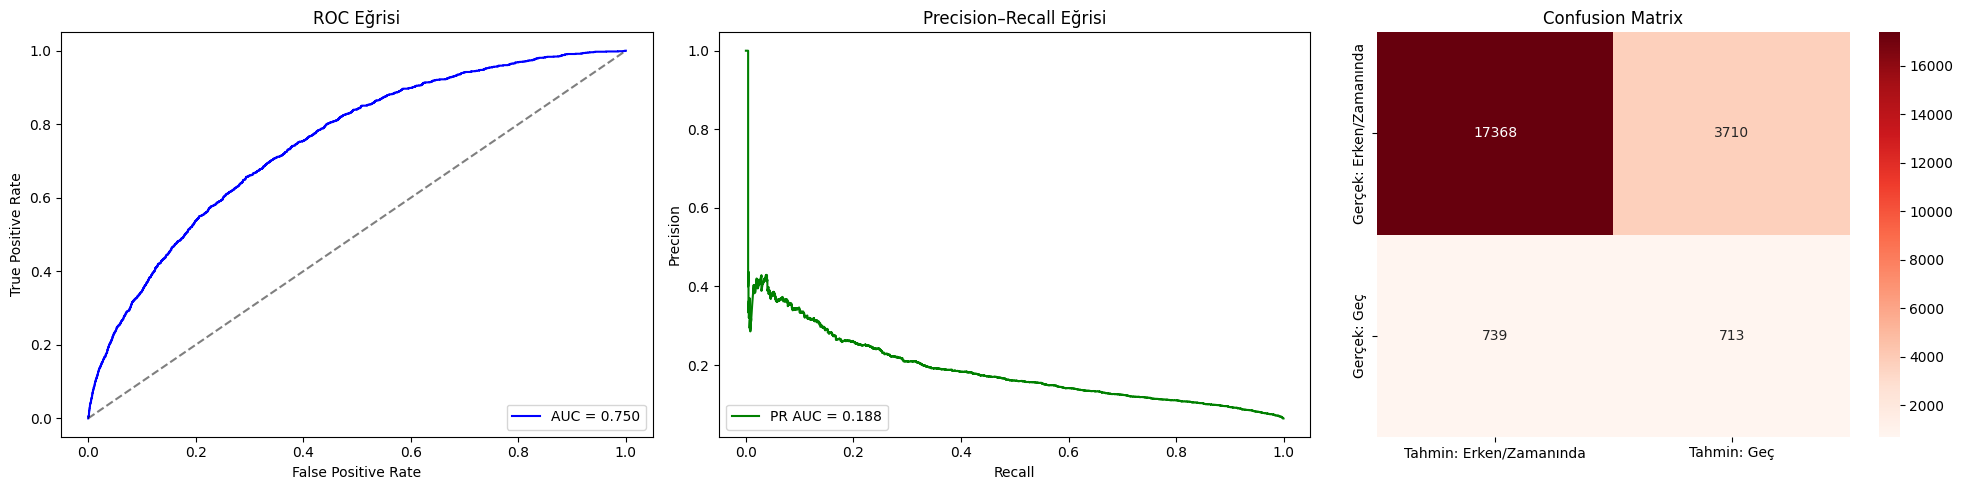

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.4)

# 1️ ROC Curve
fpr, tpr, _ = roc_curve(y_test, p)
axes[0].plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc_score(y_test, p):.3f}")
axes[0].plot([0,1],[0,1],'k--', alpha=0.5)
axes[0].set_title("ROC Eğrisi")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")

# 2️ Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, p)
axes[1].plot(rec, prec, color="green",
             label=f"PR AUC = {average_precision_score(y_test, p):.3f}")
axes[1].set_title("Precision–Recall Eğrisi")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="lower left")

# 3️ Confusion Matrix Heatmap
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Tahmin: Erken/Zamanında", "Tahmin: Geç"],
            yticklabels=["Gerçek: Erken/Zamanında", "Gerçek: Geç"],
            ax=axes[2])
axes[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()

## En Iyi Modeli Tespit

In [108]:
results = utils.base_models(Xtr_prep, y_train)

Base Models....
roc_auc: 0.7031 (LR) 
roc_auc: 0.5809 (KNN) 
roc_auc: 0.9956 (CART) 
roc_auc: 1.0 (RF) 
roc_auc: 0.9999 (XGBoost) 
roc_auc: 0.9999 (LightGBM) 


In [109]:
best_models, scores_df = utils.hyperparameter_optimization_processed_with_threshold(
    Xtr_prep, 
    y_train, 
    Xte_prep, 
    y_test, 
    utils.classifiers, 
    cv=3, 
    scoring="roc_auc"
)

Hyperparameter Optimization on Processed Data with Optimal Threshold...

########## CART ##########
roc_auc (CV Before): 0.9954
Fitting 3 folds for each of 9 candidates, totalling 27 fits
roc_auc (CV After): 0.9988
roc_auc (Test): 0.5785
Optimal F1 threshold: 0.010
F1 at optimal threshold: 0.2674

########## RF ##########
roc_auc (CV Before): 1.0
Fitting 3 folds for each of 24 candidates, totalling 72 fits
roc_auc (CV After): 1.0
roc_auc (Test): 0.7488
Optimal F1 threshold: 0.051
F1 at optimal threshold: 0.3188

########## XGBoost ##########
roc_auc (CV Before): 0.9999
Fitting 3 folds for each of 16 candidates, totalling 48 fits
roc_auc (CV After): 0.9999
roc_auc (Test): 0.6978
Optimal F1 threshold: 0.616
F1 at optimal threshold: 0.2695

########## LightGBM ##########
roc_auc (CV Before): 0.9999
Fitting 3 folds for each of 8 candidates, totalling 24 fits
roc_auc (CV After): 0.9999
roc_auc (Test): 0.6572
Optimal F1 threshold: 0.141
F1 at optimal threshold: 0.2694



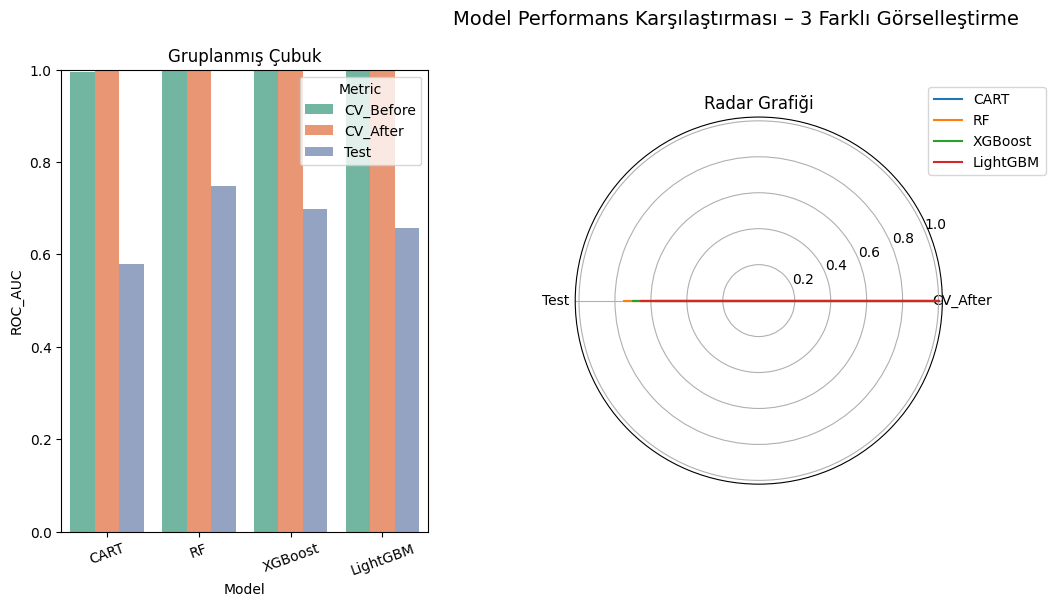

In [110]:
fig = plt.figure(figsize=(18,6))
plt.subplots_adjust(wspace=0.4)

# ============= 1️ Gruplanmış Bar =============
ax1 = fig.add_subplot(1,3,1)
scores_df_melt = scores_df.melt(id_vars="Model",
                                value_vars=["CV_Before","CV_After","Test"],
                                var_name="Metric", value_name="ROC_AUC")
sns.barplot(data=scores_df_melt, x="Model", y="ROC_AUC",
            hue="Metric", palette="Set2", ax=ax1)
ax1.set_title("Gruplanmış Çubuk")
ax1.set_ylim(0,1)
ax1.tick_params(axis="x", rotation=20)
ax1.legend(title="Metric")

# ============= 2️ Radar (Spider) =============
ax2 = fig.add_subplot(1,3,2, polar=True)
radar_df = scores_df.set_index("Model")[["CV_After","Test"]]
categories = radar_df.columns
N = len(categories)
angles = [n/float(N)*2*pi for n in range(N)]
angles += angles[:1]

for model in radar_df.index:
    values = radar_df.loc[model].tolist()
    values += values[:1]
    ax2.plot(angles, values, label=model)
    ax2.fill(angles, values, alpha=0.1)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax2.set_title("Radar Grafiği")
ax2.legend(loc="upper right", bbox_to_anchor=(1.3,1.1))


plt.suptitle("Model Performans Karşılaştırması – 3 Farklı Görselleştirme", fontsize=14)
plt.show()



### Model Performanslarının Özeti

###  ===== Tüm Modeller için Validation Curve =====

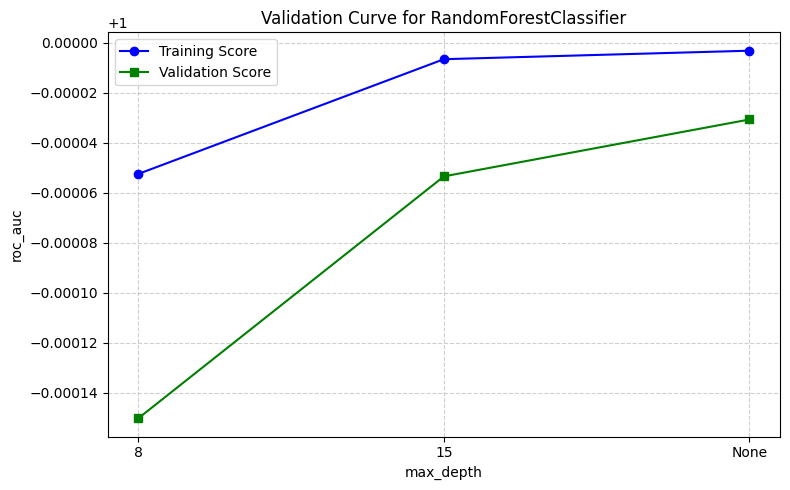

In [111]:
rf_model_obj = best_models["RF"]["model"]
param_range = [8, 15, None]  # RF max_depth aralığı
utils.val_curve_params(
    model=rf_model_obj,      # Sadece estimator
    X=Xtr_prep,
    y=y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="roc_auc",
    cv=10
)

### Train verisinde feature-target ilişkisi

In [112]:
corr_df = utils.leakage_check(X_train_ids, y_train, top_n=30)
print(corr_df)

                           abs_corr
cust_late_rate                0.822
product_late_rate             0.331
seller_late_rate              0.179
distance_km                   0.078
year                          0.041
month                         0.029
week                          0.028
payment_value_sum             0.018
cust_freq                     0.018
product_freq                  0.013
dominant_payment_type         0.013
seller_freq                   0.011
payment_installments_max      0.011
dayofweek                     0.010
boleto                        0.009
voucher                       0.008
hour                          0.007
credit_card                   0.006
debit_card                    0.005
order_approved_at_NA_FLAG     0.003
seller_count_per_order          NaN
distance_km_NA_FLAG             NaN


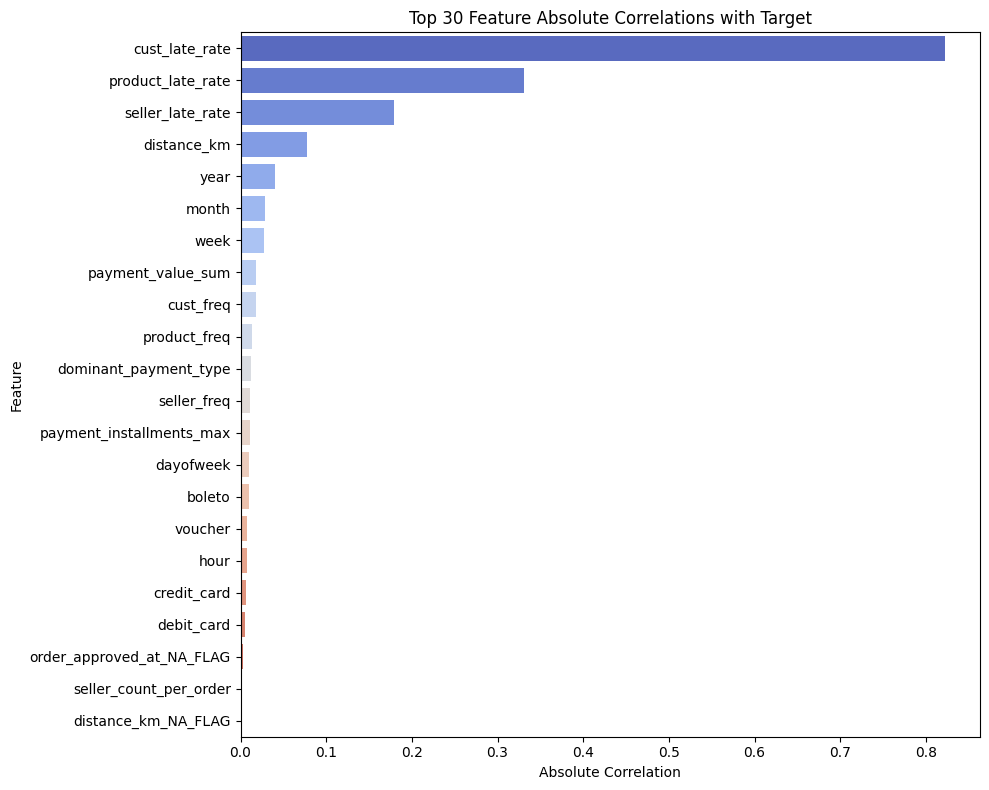

In [113]:
top_n = 30
corr_plot_df = corr_df.sort_values("abs_corr", ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=corr_plot_df,
    x="abs_corr",
    y=corr_plot_df.index,
    palette="coolwarm"
)

plt.title(f"Top {top_n} Feature Absolute Correlations with Target")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




### Gecikme Oranı Dağılımları: Train vs Test – Olası Leakage Kontrolü

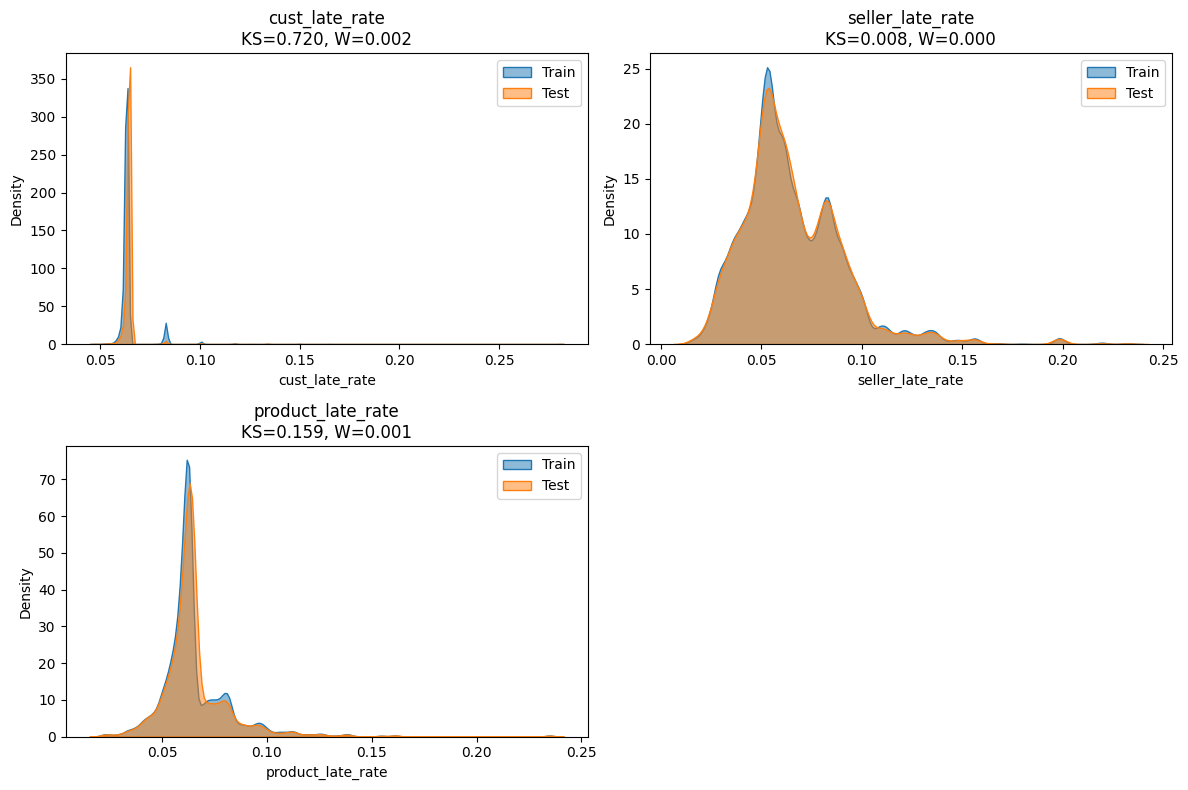

In [114]:
utils.compare_late_rate_features(X_train_ids, X_test_ids)

### Train ve Test Seti Özellik Dağılım Karşılaştırması (KS & Wasserstein)

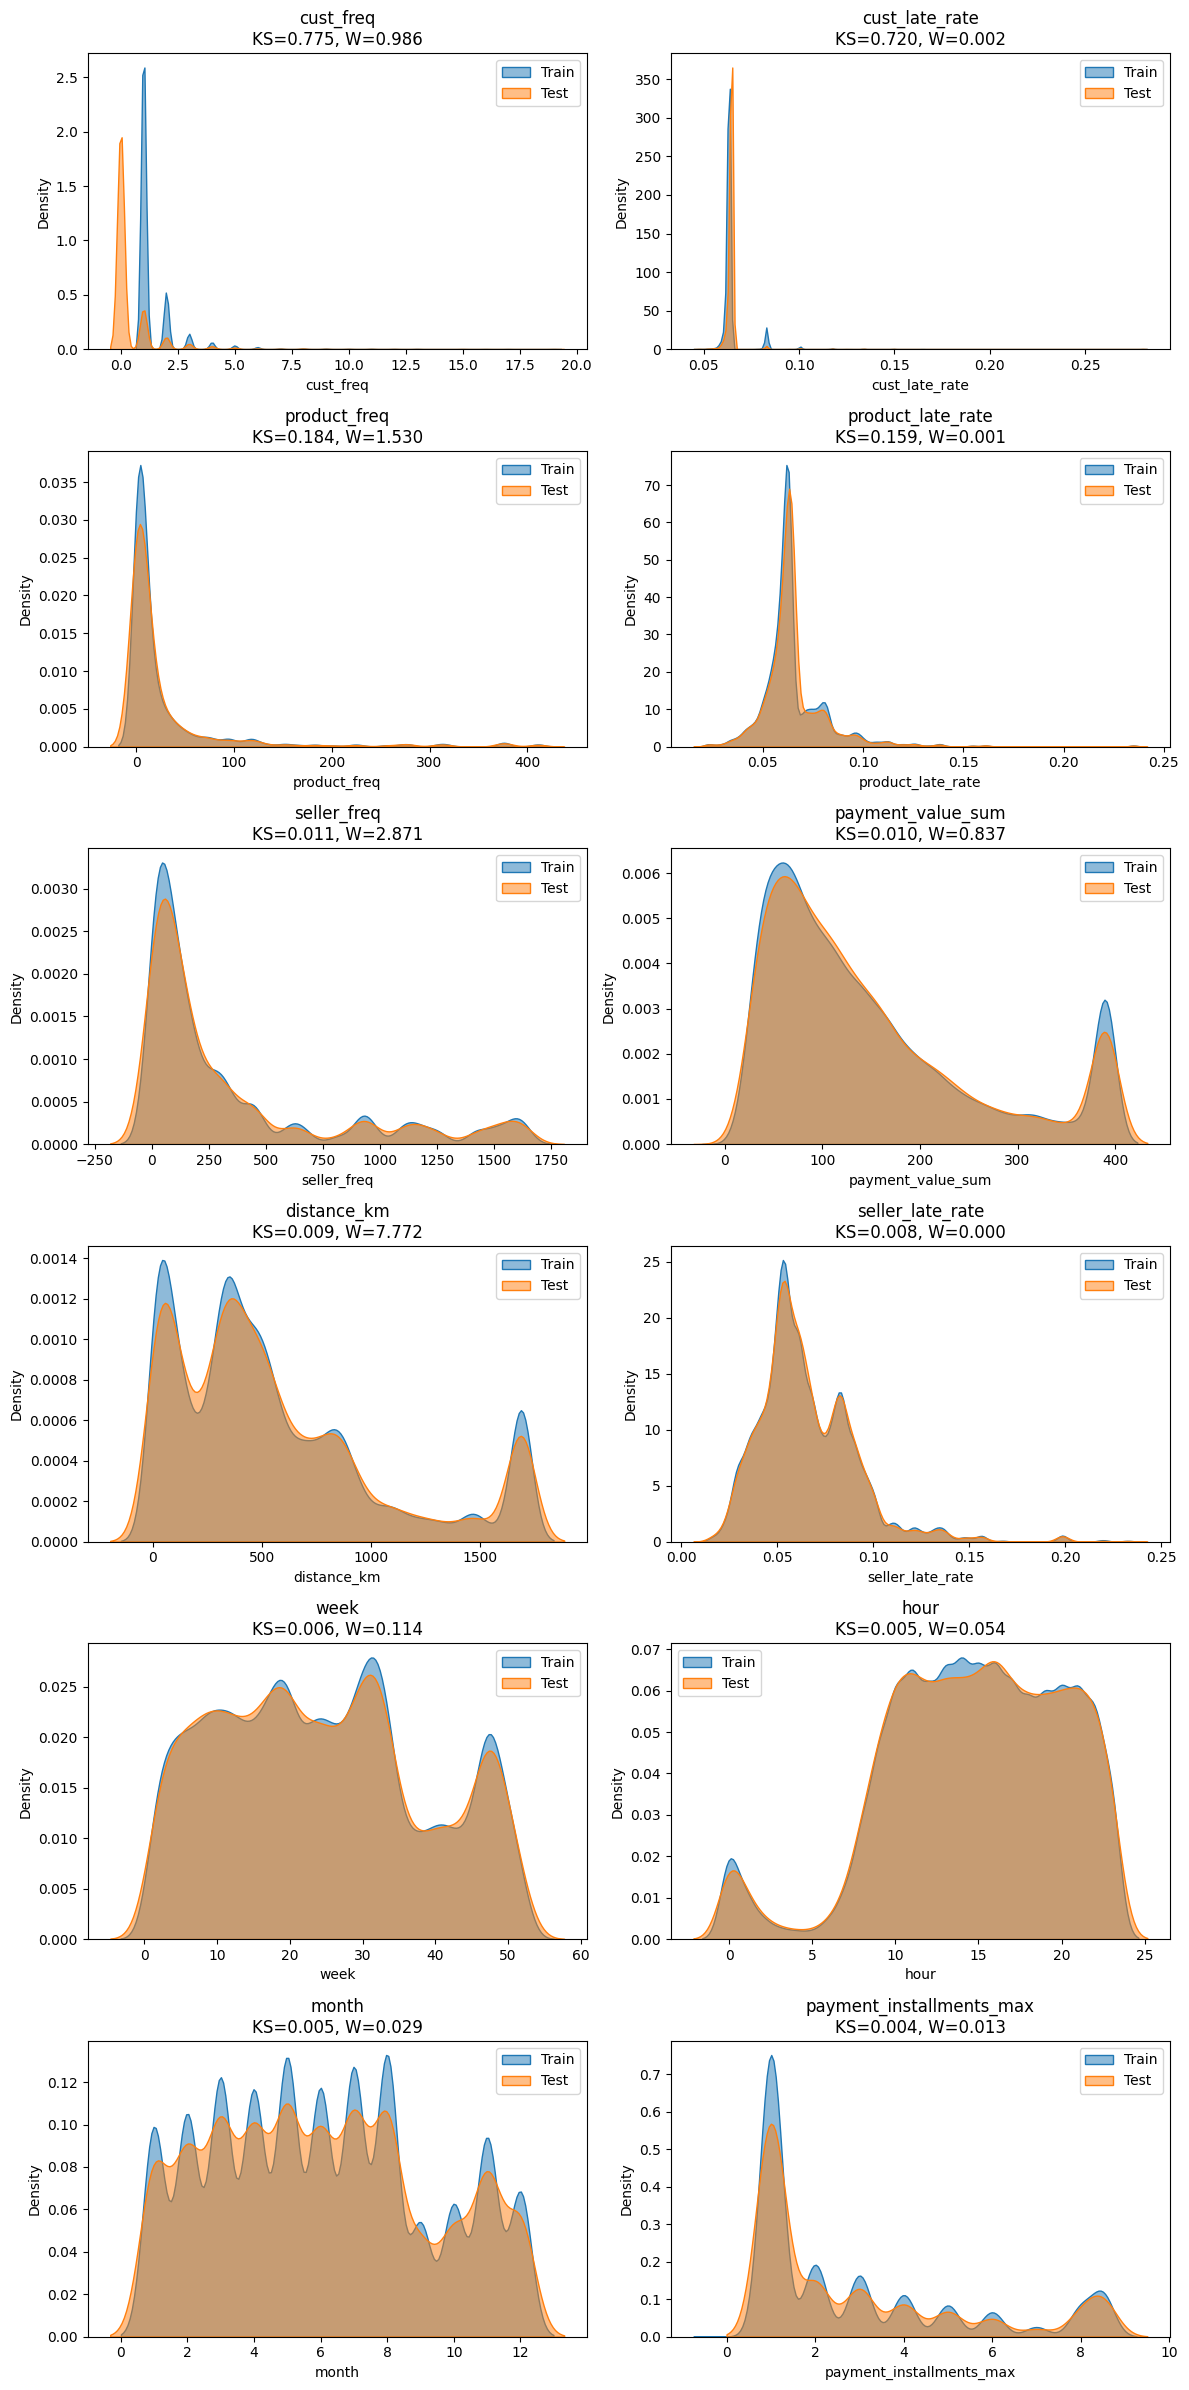

                     feature    KS  Wasserstein
15                 cust_freq 0.775        0.986
16            cust_late_rate 0.720        0.002
19              product_freq 0.184        1.530
20         product_late_rate 0.159        0.001
17               seller_freq 0.011        2.871
1          payment_value_sum 0.010        0.837
0                distance_km 0.009        7.772
18          seller_late_rate 0.008        0.000
6                       week 0.006        0.114
10                      hour 0.005        0.054
5                      month 0.005        0.029
2   payment_installments_max 0.004        0.013
9                  dayofweek 0.003        0.012
12               credit_card 0.002        0.002
11                    boleto 0.001        0.001


In [115]:
results_df = utils.compare_feature_distributions(X_train_ids, X_test_ids, max_plots=12)
print(results_df.head(15))


### Final modelini kaydet

In [116]:
joblib.dump(rf_model_obj, "rf_final.pkl")
rf_model_from_disc = joblib.load("rf_final.pkl")

# Geciken siparişler için "kaç gün gecikir?” Tahmini

### Buradaki amaç: Sadece is_late = 1 olan satırlarla delay_class hedef değişkenine bir regresyon/çoklu sınıf modeli kurmak.

Gecikme Analizi ve Tahmini

1. Veri Hazırlığı:
   - 'fact_order_clean' veri setinden yalnızca gecikmiş siparişleri (is_late == 1) seçtik.
   - Hedef değişken olarak 'delay_days' alındı.
   - 'delay_days', 'is_late' ve 'delay_class' kolonları X veri setinden çıkarıldı.
   - Eksik değerler ve zamanla ilgili özellikler eklendi.
   - Kaçak veri (leakage) oluşturan sütunlar çıkarıldı.
   - Categorical ID değişkenleri uygun şekilde encode edildi.
   - Pipeline ile scaling ve preprocessing yapıldı.

2. Modelleme:
   - Ağac tabanlı modeller (Decision Tree, Random Forest, XGBoost, LightGBM) kullanıldı.
   - Hyperparameter optimizasyonu GridSearchCV ile gerçekleştirildi.
   - En iyi modeller belirlendi ve test verisi üzerinde değerlendirildi.

3. Regresyon:
   - Amaç, gecikmiş siparişlerin kaç gün gecikeceğini sayısal olarak tahmin etmektir.
   - Önceki adımda yaptığımız sınıflandırma (is_late) yalnızca gecikme olup olmadığını tahmin ediyordu.
   - Regresyon ile hedef değişken sürekli olduğundan model, siparişin gecikme gün sayısını öngörür.
   - Performans, RMSE, MAE veya R² gibi regresyon metrikleri ile ölçülür.

In [117]:
TARGET_DELAY = "delay_class"
mask = fact_order_clean[TARGET_DELAY] != 0

X_delay = fact_order_clean.loc[mask].drop(columns=[TARGET_DELAY])
y_delay = fact_order_clean.loc[mask, TARGET_DELAY]

# stratify: multi-class dengesizliğini korur
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_delay, y_delay, test_size=0.2, random_state=42, stratify=y_delay
)

# Feature engineering
X_train_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_train_d)
)
X_test_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_test_d)
)

# Payment type encoding
pt_encoder_d = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat_d = pt_encoder_d.fit_transform(X_train_feat_d)
X_test_feat_d  = pt_encoder_d.transform(X_test_feat_d)

# Leakage kolonlarını temizle
X_train_feat_d = utils.drop_leakage_columns(X_train_feat_d)
X_test_feat_d  = utils.drop_leakage_columns(X_test_feat_d)

# ID encoding
X_train_ids_d, X_test_ids_d, id_models_d = utils.add_all_id_encodings(
    X_train_feat_d, X_test_feat_d, y_train_d,
    id_plan=[("cusUni","cust"), ("seller_id_pref","seller"), ("product_id_pref","product")]
)

# Preprocessor
preprocessor_d = utils.build_full_preprocessor_leakfree(X_train_ids_d)
Xtr_prep_d = preprocessor_d.fit_transform(X_train_ids_d, y_train_d)
Xte_prep_d = preprocessor_d.transform(X_test_ids_d)

print("Delay_class Xtr_prep shape:", Xtr_prep_d.shape)
print("Delay_class Xte_prep shape:", Xte_prep_d.shape)

Delay_class Xtr_prep shape: (5809, 86)
Delay_class Xte_prep shape: (1453, 86)


In [118]:
X_train_feat_d.columns

Index(['cusUni', 'customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 'distance_km', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order', 'year', 'month', 'week', 'distance_km_NA_FLAG', 'order_approved_at_NA_FLAG', 'dayofweek', 'hour', 'boleto', 'credit_card', 'debit_card', 'voucher', 'dominant_payment_type'], dtype='object')

###  Çok sınıflı hiperparametre optimizasyonu

In [119]:
le = LabelEncoder()
y_train_d = le.fit_transform(y_train_d)
y_test_d  = le.transform(y_test_d)

best_models_delay_class, scores_df = utils.hyperparameter_optimization_multiclass(
    Xtr_prep_d,
    y_train_d,
    Xte_prep_d,
    y_test_d,
    utils.multi_classifiers,
    cv=3,
    scoring="f1_weighted"   # dengesiz çoklu sınıflar için uygun
)
scores_df.to_csv("metrics.csv", index=False)
print("metrics.csv kaydedildi")


Hyperparameter Optimization for Multi-class...

########## CART ##########
f1_weighted (CV Before): 0.9957
Fitting 3 folds for each of 36 candidates, totalling 108 fits
f1_weighted (CV After): 0.9964
f1_weighted (Test): 0.3840

########## RF ##########
f1_weighted (CV Before): 0.9878
Fitting 3 folds for each of 162 candidates, totalling 486 fits
f1_weighted (CV After): 0.9908
f1_weighted (Test): 0.3627

########## XGBoost ##########
f1_weighted (CV Before): 0.9974
Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_weighted (CV After): 0.9979
f1_weighted (Test): 0.3668

########## LightGBM ##########
f1_weighted (CV Before): 0.9976
Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_weighted (CV After): 0.9979
f1_weighted (Test): 0.2491

metrics.csv kaydedildi


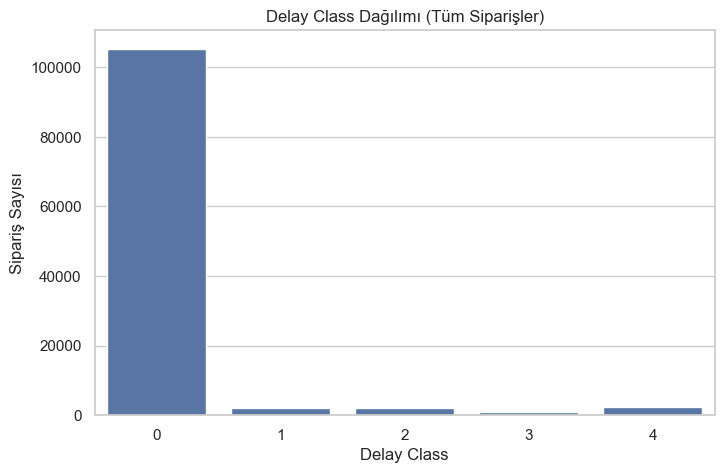

In [120]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(x="delay_class", data=fact_order_clean, order=sorted(fact_order_clean["delay_class"].unique()))
plt.title("Delay Class Dağılımı (Tüm Siparişler)")
plt.xlabel("Delay Class")
plt.ylabel("Sipariş Sayısı")
plt.show()

Verinin %93.6’sı gecikme olmayan siparişlerden oluşuyor (0 sınıf). Bu aşırı dengesizlik, modelin çoğunluk sınıfına odaklanmasına ve nadir sınıfların tahmininde başarısız olmasına yol açıyor.

### Modelleme: 0 sınıf haric

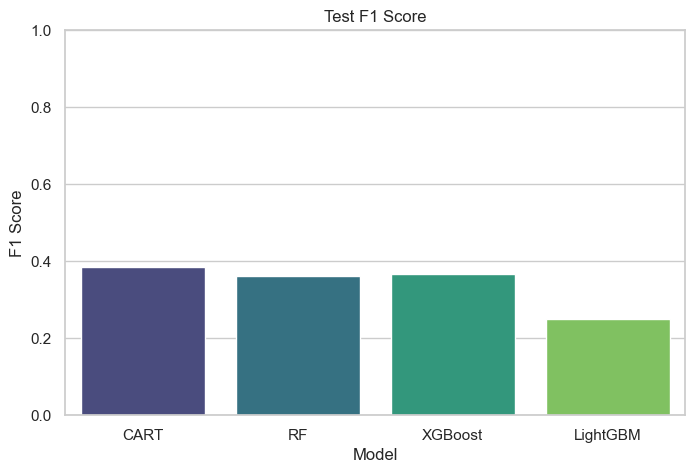

In [121]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Test", data=scores_df, palette="viridis")
plt.ylim(0,1)
plt.title("Test F1 Score")
plt.ylabel("F1 Score")
plt.show()

Test skorları kısmen yükselse de hâlâ yeterli değil. Sınıf dengesizliği ve düşük veri hacmi nedeniyle, nadir gecikme sınıflarının tahmini güvenilir değil.

### delay_class degiskeni tahminlemesinde Çok Sınıflı Model Performans Karşılaştırması

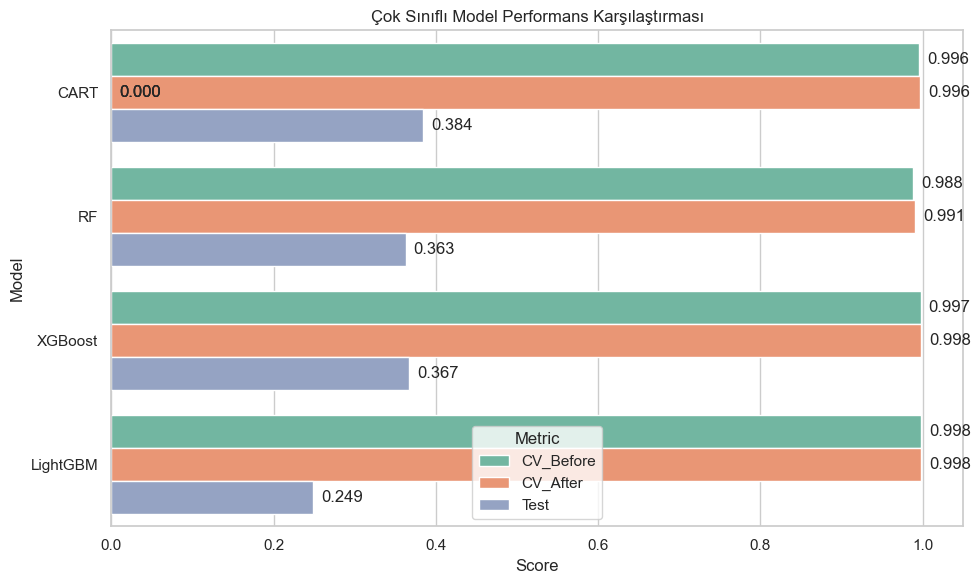

In [124]:
df = scores_df.copy()

# Uzun formata çevir (melt) -> CV_Before, CV_After, Test tek sütunda
df_melt = df.melt(id_vars="Model", value_vars=["CV_Before","CV_After","Test"],
                  var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
ax = sns.barplot(x="Score", y="Model", hue="Metric", data=df_melt, palette="Set2")

# Barların üzerine skorları yaz
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,               # x konumu (barın biraz sağı)
             p.get_y() + p.get_height()/2,  # y konumu (barın ortası)
             f"{width:.3f}", va="center")

plt.title("Çok Sınıflı Model Performans Karşılaştırması")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1.05)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

## Confusion Matrix Örnekleri

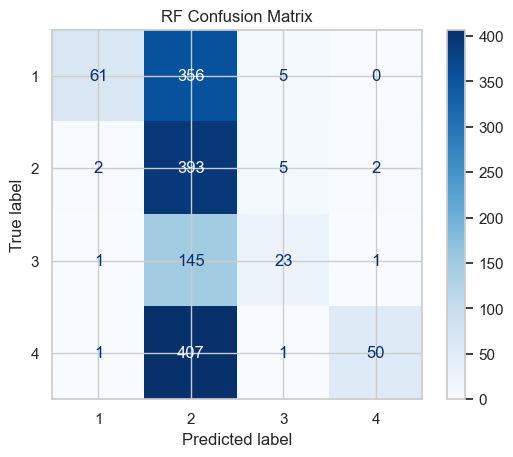

In [125]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_models_delay_class["RF"], Xte_prep_d, y_test_d,
    display_labels=[1,2,3,4],
    cmap=plt.cm.Blues
)
plt.title("RF Confusion Matrix")
plt.show()

In [ ]:
#metrics_df.to_csv("metrics.csv", index=False, sep=";")
#preds.to_csv("predictions.csv", index=False, sep=";")
#scores_df.to_csv("model_score_train_test.csv", index=False, sep=";")

Model, bazı sınıfları karıştırıyor, özellikle 2 ve 3 sınıflarında doğruluk düşük.

Nadir sınıfların tahmini halen zor, dengesiz veri etkisi sürüyor.

### Sonuç 

Modeller çoğunluk sınıfına aşırı uyum sağlıyor ve nadir sınıfların tahmin başarısı düşük.

Sınıf dengesizliği ve veri azlığı nedeniyle tahminler güvenilir değil.
    

Delay_class tahmini, veri setindeki aşırı dengesizlik ve nadir sınıf sayısı nedeniyle anlamlı ve güvenilir bir analiz sağlamıyor. Bu nedenle model sonuçları sunulmuş, fakat detaylı tahmin yapılmamıştır.

Analiz, verinin mevcut dağılımını, model skorlarını ve sınıf tahmin performansını grafik ve görselle destekleyerek açıklıyor. Bu aşamada daha ileri tahminler yapmak riskli olur.    